In [1]:
# Hide the codes
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import scipy as sp
import pandas as pd
import pickle as pk
import os
from scipy.ndimage import uniform_filter1d
from numpy.polynomial import Polynomial
from sklearn.metrics import r2_score
from sklearn.metrics import auc
from itertools import zip_longest

In [2]:
def multi_plot_waveform(signals: list, titles: list, num_row: int = 1, num_col: int = 1, fig_size=(10, 5),
                        suptitle: str = None, x_suptitle=0.5, y_suptitle=0.98, label_outer=True):
    """ Signals should be a list of arrays (arrays are signals)
        titles should be list of strings containing the title of each plot """

    assert num_row * num_col >= len(signals), f'Number of signals to be plotted can not be larger than' \
                                              f' number of row multiplied by number of columns'

    length = len(signals)
    signals = np.array(signals)
    titles = np.array(titles, dtype=object)
    temp = num_row * num_col - len(signals)
    if temp > 0:  # pad the arrays in case to reshape them to (num_row, num_col)
        signals = np.pad(signals, (0, temp), 'edge')
        titles = np.pad(titles, (0, temp), 'edge')

    if num_row == 1 and num_col == 1:
        plt.figure(figsize=fig_size)
        plt.suptitle(suptitle)
        plt.title(titles[0])
        plt.ylabel('Amplitude')
        librosa.display.waveshow(signals[0])

    else:
        if num_col == 1:
            fig, axs = plt.subplots(num_row, 1, figsize=fig_size)
            fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
            for i in range(num_row):
                librosa.display.waveshow(signals[i], ax=axs[i])
                axs[i].set_title(titles[i])

        elif num_row == 1:
            fig, axs = plt.subplots(1, num_col, figsize=fig_size)
            fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
            for j in range(num_col):
                librosa.display.waveshow(signals[j], ax=axs[j])
                axs[j].set_title(titles[j])

        else:
            signals_reshaped = signals.reshape((num_row, num_col, -1))
            titles_reshaped = titles.reshape((num_row, num_col))
            fig, axs = plt.subplots(num_row, num_col, figsize=fig_size)
            fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
            for i in range(num_row):
                for j in range(num_col):
                    librosa.display.waveshow(signals_reshaped[i, j], ax=axs[i, j])
                    axs[i, j].set_title(titles_reshaped[i, j])
            for ax in axs.flat[length:]:
                ax.set_visible(False)

        for ax in axs.flat:
            ax.set(ylabel='Amplitude')
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            
        if label_outer:
            for ax in axs.flat:
                ax.label_outer()         

        fig.tight_layout()

In [3]:
def multi_plot_spectrogram(D_signals: list, titles: list, plot: str, num_row: int = 1, num_col: int = 1, fig_size=(10, 5),
                           suptitle: str = None, x_suptitle=0.5, y_suptitle=0.92, label_outer=True, sample_rate=22050,
                           hop_length=256, x_axis='time', y_axis=None, cax=None, orientation='vertical'):
    """ Signals should be a list of arrays (arrays are signals)
        titles should be list of strings containing the title of each plot
        plot determines which type of diagram should be plotted. It can be 'spec', 'mel_spec', 'mfcc'
        y_axis can take different ranges defaulted in 'log' (see https://librosa.org/doc/main/generated/librosa.display.specshow.html#librosa.display.specshow)
        cax determines the location of color bar
        orientation determines the orientation of color bar, either vertical or horizontal """
    
    global m
    if cax is None:
        cax = [0.95, 0.15, 0.03, 0.7]

    assert num_row * num_col >= len(D_signals), f'Number of signals to be plotted can not be larger than' \
                                                f' number of row multiplied by number of columns'

    length = len(D_signals)
    signals = np.array(D_signals)
    titles = np.array(titles, dtype=object)
    temp = num_row * num_col - len(signals)
    if temp > 0:  # pad the arrays in case to reshape them to (num_row, num_col)
        signals = np.pad(signals, (0, temp), 'edge')
        titles = np.pad(titles, (0, temp), 'edge')

    if num_row == 1 and num_col == 1:
        plt.figure(figsize=fig_size)
        plt.suptitle(suptitle)
        plt.title(titles[0])
        #plt.ylabel('Hz')
        librosa.display.specshow(signals[0], sr=sample_rate, hop_length=hop_length, x_axis=x_axis, y_axis=y_axis)
        if plot == 'mfcc':
            plt.colorbar(format="%+2.f", orientation=orientation)
        else:
            plt.colorbar(format="%+2.f dB", orientation=orientation)

    else:
        if num_col == 1:
            fig, axs = plt.subplots(num_row, 1, figsize=fig_size)
            fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
            for i in range(num_row):
                m = librosa.display.specshow(signals[i], ax=axs[i], sr=sample_rate, hop_length=hop_length,
                                             x_axis=x_axis, y_axis=y_axis)
                axs[i].set_title(titles[i])
            #fig.colorbar(m, cax=plt.axes(cax), format="%+2.f dB", orientation=orientation)

        elif num_row == 1:
            fig, axs = plt.subplots(1, num_col, figsize=fig_size)
            fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
            for j in range(num_col):
                m = librosa.display.specshow(signals[j], ax=axs[j], sr=sample_rate, hop_length=hop_length,
                                             x_axis=x_axis, y_axis=y_axis)
                axs[j].set_title(titles[j])
                #fig.colorbar(m, cax=plt.axes(cax), format="%+2.f dB", orientation=orientation)

        else:
            _, freq_bins, frames = signals.shape
            signals_reshaped = signals.reshape((num_row, num_col, freq_bins, -1))
            titles_reshaped = titles.reshape((num_row, num_col))
            fig, axs = plt.subplots(num_row, num_col, figsize=fig_size)
            fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
            for i in range(num_row):
                for j in range(num_col):
                    m = librosa.display.specshow(signals_reshaped[i, j], ax=axs[i, j], sr=sample_rate,
                                                 hop_length=hop_length, x_axis=x_axis, y_axis=y_axis)
                    axs[i, j].set_title(titles_reshaped[i, j])
            #fig.colorbar(m, cax=plt.axes(cax), format="%+2.f dB", orientation=orientation)
            for ax in axs.flat[length:]:
                ax.set_visible(False)
        
        if plot == 'mfcc':
            fig.colorbar(m, cax=plt.axes(cax), format="%+2.f", orientation=orientation)
            for ax in axs.flat:
                ax.set(ylabel='Coefficients')
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            fig.colorbar(m, cax=plt.axes(cax), format="%+2.f dB", orientation=orientation)
            for ax in axs.flat:
                ax.set(ylabel='Hz')
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
             
        if label_outer:
            for ax in axs.flat:
                ax.label_outer()
                #ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


In [20]:
def multi_plot_spectral(signals: list, titles: list, num_row: int = 1, num_col: int = 1, fig_size=(10, 5),
                        suptitle: str = None, x_suptitle=0.5, y_suptitle=0.92, y_label: str = None, label_outer=True,
                        sample_rate=22050, frame_size=None, hop_length=256):
    """ Signals should be a list of arrays (arrays are signals). Signals can be 1 dimensional features like
        spectral centroid. This function also can plot grouped features, but to do so, signals should be
        a list of lists of arrays for which each list in the signal list is plotted in a same color.
        Titles should be list of strings containing the title of each plot. For grouped features, titles should be
        a list of lists of strings"""

    assert len(set(map(len, signals))) == 1, f'All elements of the signal list should have the same length'
    assert len(set(map(len, titles))) == 1, f'All elements of the titles list should have the same length'

    length = len(signals)
    signals = np.array(signals)
    titles = np.array(titles, dtype=object)
    temp = num_row * num_col - length
    if temp > 0:  # pad the arrays in case to reshape them to (num_row, num_col)
        signals = np.pad(signals, (0, temp), 'edge')
        titles = np.pad(titles, (0, temp), 'edge')

    if num_row == 1 and num_col == 1:
        if length == 1:
            plt.figure(figsize=fig_size)
            plt.suptitle(suptitle)
            plt.title(titles[0])
            plt.xlabel('Time')
            plt.ylabel(y_label)
            times = librosa.times_like(signals[0], sr=sample_rate, hop_length=hop_length, n_fft=frame_size)
            plt.plot(times, signals[0])
        else:
            plt.figure(figsize=fig_size)
            plt.suptitle(suptitle)
            plt.xlabel('Time')
            plt.ylabel(y_label)
            color = iter(cm.rainbow(np.linspace(0, 1, length)))
            if len(signals.shape) < 3:
                for i in range(length):
                    c = next(color)
                    times = librosa.times_like(signals[i], sr=sample_rate, hop_length=hop_length, n_fft=frame_size)
                    plt.plot(times, signals[i], color=c, label=titles[i])
                    plt.legend()
            else:
                for i in range(length):
                    c = next(color)
                    for j in range(signals.shape[1]):
                        times = librosa.times_like(signals[i, j], sr=sample_rate, hop_length=hop_length,
                                                   n_fft=frame_size)
                        plt.plot(times, signals[i, j], color=c, label=titles[i, j])
                        plt.legend()

    else:
        if num_col == 1:
            fig, axs = plt.subplots(num_row, 1, figsize=fig_size)
            fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
            for i in range(num_row):
                times = librosa.times_like(signals[i], sr=sample_rate, hop_length=hop_length, n_fft=frame_size)
                axs[i].plot(times, signals[i])
                axs[i].set_title(titles[i])

        elif num_row == 1:
            fig, axs = plt.subplots(1, num_col, figsize=fig_size)
            fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
            for i in range(num_col):
                times = librosa.times_like(signals[i], sr=sample_rate, hop_length=hop_length, n_fft=frame_size)
                axs[i].plot(times, signals[i])
                axs[i].set_title(titles[i])

        else:
            signals_reshaped = signals.reshape((num_row, num_col, -1))
            titles_reshaped = titles.reshape((num_row, num_col))
            fig, axs = plt.subplots(num_row, num_col, figsize=fig_size)
            fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
            for i in range(num_row):
                for j in range(num_col):
                    times = librosa.times_like(signals_reshaped[i, j], sr=sample_rate, hop_length=hop_length,
                                               n_fft=frame_size)
                    axs[i, j].plot(times, signals_reshaped[i, j])
                    axs[i, j].set_title(titles_reshaped[i, j])
            for ax in axs.flat[length:]:
                ax.set_visible(False)

        for ax in axs.flat:
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        if label_outer:
            for ax in axs.flat:
                ax.label_outer()
            for ax in axs.flat[:: num_col]:
                ax.set(ylabel=y_label)
            for ax in axs.flat[-num_col:]:
                ax.set(xlabel='Time')
        else:
            for ax in axs.flat[:: num_col]:
                ax.set(ylabel=y_label)
            for ax in axs.flat[:-num_col]:
                ax.set_xticklabels([])
            for ax in axs.flat[-num_col:]:
                ax.set(xlabel='Time')

        fig.tight_layout()

In [5]:
def multi_plot_overlap_waveshow(background_signals: list, foreground_signals: list, titles: list,
                                labels_foreground_signals: list, num_row: int = 1, num_col: int = 1,
                                legend_location: str = 'lower right', legend_fontsize=10, fig_size=(10, 5),
                                suptitle: str = None, x_suptitle=0.5, y_suptitle=0.92, label_outer=True,
                                sample_rate=22050, frame_size=None, hop_length=256, color_back_sig='b',
                                alpha_back_sig=None):
    """ background_signals should be a list of arrays (arrays are signals). Signals are plotted in time domain
        foreground_signals should be a list of lists containing array of signals to be plotted overlapping
        with background plot
        titles should be a list of strings containing the title of each plot
        labels_foreground_signals is a list of strings containing the label of each foreground signal """

    length_back = len(background_signals)
    length_fore = len(foreground_signals)
    length_fore_per_element = len(foreground_signals[0])

    assert num_row * num_col >= len(background_signals), f'Number of signals to be plotted can not be larger than' \
                                                         f' number of row multiplied by number of columns'

    assert len(set(map(len, foreground_signals))) == 1, f'All elements of foreground signal list should have' \
                                                        f' the same length'

    assert length_back == length_fore, f'Number of background signals and foreground signals are not consistent'

    assert len(
        labels_foreground_signals) == length_fore_per_element, f'Foreground signals and the corresponding labels' \
                                                               f' are not consistent'

    signals_back = np.array(background_signals)
    signals_fore = np.array(foreground_signals)
    titles = np.array(titles, dtype=object)
    labels_foreground_signals = np.array(labels_foreground_signals, dtype=object)

    temp = num_row * num_col - length_back
    if temp > 0:  # pad the arrays in case to reshape them to (num_row, num_col)
        signals_back = np.pad(signals_back, (0, temp), 'edge')
        # signals_fore = np.vstack((signals_fore, signals_fore[-1].reshape((1, signals_fore.shape[1], -1))))
        signals_fore = np.repeat(signals_fore, [1 for i in range(length_fore - 1)] + [temp + 1], axis=0)
        titles = np.pad(titles, (0, temp), 'edge')

    if num_row == 1 and num_col == 1:
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        fig.suptitle(suptitle)
        librosa.display.waveshow(y=signals_back[0], ax=ax, sr=sample_rate, color=color_back_sig, alpha=alpha_back_sig)
        color = iter(cm.rainbow(np.linspace(0, 1, length_fore_per_element)))
        for i in range(length_fore_per_element):
            times = librosa.times_like(signals_fore[0, i], sr=sample_rate, hop_length=hop_length, n_fft=frame_size)
            c = next(color)
            ax.plot(times, signals_fore[0, i], label=labels_foreground_signals[i], color=c)
        ax.legend(loc=legend_location, fontsize=legend_fontsize)
        ax.set(title=titles[0])
        ax.set(ylabel='Amplitude')

    else:
        if num_col == 1:
            fig, axs = plt.subplots(num_row, 1, figsize=fig_size)
            fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
            for i in range(num_row):
                librosa.display.waveshow(y=signals_back[i], ax=axs[i], sr=sample_rate, color=color_back_sig,
                                         alpha=alpha_back_sig)
                color = iter(cm.rainbow(np.linspace(0, 1, length_fore_per_element)))
                for j in range(length_fore_per_element):
                    times = librosa.times_like(signals_fore[i, j], sr=sample_rate, hop_length=hop_length,
                                               n_fft=frame_size)
                    c = next(color)
                    axs[i].plot(times, signals_fore[i, j], label=labels_foreground_signals[j], color=c)
                axs[i].legend(loc=legend_location, fontsize=legend_fontsize)
                axs[i].set(ylabel='Amplitude')
                axs[i].set_title(titles[i])
                axs[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        elif num_row == 1:
            fig, axs = plt.subplots(1, num_col, figsize=fig_size)
            fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
            for j in range(num_col):
                librosa.display.waveshow(y=signals_back[j], ax=axs[j], sr=sample_rate, color=color_back_sig,
                                         alpha=alpha_back_sig)
                color = iter(cm.rainbow(np.linspace(0, 1, length_fore_per_element)))
                for i in range(length_fore_per_element):
                    times = librosa.times_like(signals_fore[j, i], sr=sample_rate, hop_length=hop_length,
                                               n_fft=frame_size)
                    c = next(color)
                    axs[j].plot(times, signals_fore[j, i], label=labels_foreground_signals[i], color=c)
                axs[j].legend(loc=legend_location, fontsize=legend_fontsize)
                axs[j].set(ylabel='Amplitude')
                axs[j].set_title(titles[j])
                axs[j].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        else:
            signals_back_reshaped = signals_back.reshape((num_row, num_col, -1))
            signals_fore_reshaped = signals_fore.reshape((num_row, num_col, signals_fore.shape[1], -1))
            titles_reshaped = titles.reshape((num_row, num_col))
            fig, axs = plt.subplots(num_row, num_col, figsize=fig_size)
            fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
            for i in range(num_row):
                for j in range(num_col):
                    librosa.display.waveshow(signals_back_reshaped[i, j], ax=axs[i, j], sr=sample_rate,
                                             color=color_back_sig, alpha=alpha_back_sig)
                    color = iter(cm.rainbow(np.linspace(0, 1, length_fore_per_element)))
                    for k in range(length_fore_per_element):
                        times = librosa.times_like(signals_fore_reshaped[i, j, k], sr=sample_rate,
                                                   hop_length=hop_length, n_fft=frame_size)
                        c = next(color)
                        axs[i, j].plot(times, signals_fore_reshaped[i, j, k], label=labels_foreground_signals[k],
                                       color=c)
                    axs[i, j].legend(loc=legend_location, fontsize=legend_fontsize)
                    axs[i, j].set_title(titles_reshaped[i, j])

            for ax in axs.flat[length_back:]:
                ax.set_visible(False)

        if label_outer:
            for ax in axs.flat:
                ax.label_outer()
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            for ax in axs.flat:
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            for ax in axs.flat[: -num_col]:
                ax.set(xlabel='')
                ax.set_xticklabels([])
            for ax in axs.flat[: : num_col]:
                ax.set(ylabel='Amplitude')

In [6]:
def multi_plot_overlap_specshow(background_signals: list, foreground_signals: list, titles: list,
                                labels_foreground_signals: list, plot: str, num_row: int = 1, num_col: int = 1,
                                legend_location: str = 'lower right', legend_fontsize=10, fig_size=(10, 5),
                                suptitle: str = None, x_suptitle=0.5, y_suptitle=0.92, label_outer=True,
                                sample_rate=22050, frame_size=None, hop_length=256, x_axis='time', y_axis=None,
                                cax=None, orientation='vertical'):
    global m
    if cax is None:
        cax = [0.95, 0.15, 0.03, 0.7]

    length_back = len(background_signals)
    length_fore = len(foreground_signals)
    length_fore_per_element = len(foreground_signals[0])

    assert num_row * num_col >= len(background_signals), f'Number of signals to be plotted can not be larger than' \
                                                         f' number of row multiplied by number of columns'

    assert len(set(map(len, foreground_signals))) == 1, f'All elements of foreground signal list should have' \
                                                        f' the same length'

    assert length_back == length_fore, f'Number of background signals and foreground signals are not consistent'

    assert len(labels_foreground_signals) == length_fore_per_element, f'Foreground signals and the corresponding' \
                                                                      f' labels are not consistent'

    signals_back = np.array(background_signals)
    signals_fore = np.array(foreground_signals)
    titles = np.array(titles, dtype=object)
    labels_foreground_signals = np.array(labels_foreground_signals, dtype=object)

    temp = num_row * num_col - length_back
    if temp > 0:  # pad the arrays in case to reshape them to (num_row, num_col)
        signals_back = np.pad(signals_back, (0, temp), 'edge')
        # signals_fore = np.vstack((signals_fore, signals_fore[-1].reshape((1, signals_fore.shape[1], -1))))
        signals_fore = np.repeat(signals_fore, [1 for i in range(length_fore - 1)] + [temp + 1], axis=0)
        titles = np.pad(titles, (0, temp), 'edge')

    if num_row == 1 and num_col == 1:
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        fig.suptitle(suptitle)
        m = librosa.display.specshow(signals_back[0], ax=ax, sr=sample_rate, n_fft=frame_size, hop_length=hop_length,
                                     x_axis=x_axis, y_axis=y_axis)
        color = iter(cm.rainbow(np.linspace(0, 1, length_fore_per_element)))
        for i in range(length_fore_per_element):
            times = librosa.times_like(signals_fore[0, i], sr=sample_rate, hop_length=hop_length, n_fft=frame_size)
            c = next(color)
            ax.plot(times, signals_fore[0, i], label=labels_foreground_signals[i], color=c)
        ax.legend(loc=legend_location, fontsize=legend_fontsize)
        ax.set(title=titles[0])
        if plot == 'mfcc':
            fig.colorbar(m, cax=plt.axes(cax), format="%+2.f", orientation=orientation)
        else:
            fig.colorbar(m, cax=plt.axes(cax), format="%+2.f dB", orientation=orientation)
            ax.set(ylabel='Hz')

    else:
        if num_col == 1:
            fig, axs = plt.subplots(num_row, 1, figsize=fig_size)
            fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
            for i in range(num_row):
                m = librosa.display.specshow(signals_back[i], ax=axs[i], sr=sample_rate, n_fft=frame_size,
                                             hop_length=hop_length, x_axis=x_axis, y_axis=y_axis)
                color = iter(cm.rainbow(np.linspace(0, 1, length_fore_per_element)))
                for j in range(length_fore_per_element):
                    times = librosa.times_like(signals_fore[i, j], sr=sample_rate, hop_length=hop_length,
                                               n_fft=frame_size)
                    c = next(color)
                    axs[i].plot(times, signals_fore[i, j], label=labels_foreground_signals[j], color=c)
                axs[i].legend(loc=legend_location, fontsize=legend_fontsize)
                axs[i].set_title(titles[i])

        elif num_row == 1:
            fig, axs = plt.subplots(1, num_col, figsize=fig_size)
            fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
            for j in range(num_col):
                m = librosa.display.specshow(signals_back[j], ax=axs[j], sr=sample_rate, n_fft=frame_size,
                                             hop_length=hop_length, x_axis=x_axis, y_axis=y_axis)
                color = iter(cm.rainbow(np.linspace(0, 1, length_fore_per_element)))
                for i in range(length_fore_per_element):
                    times = librosa.times_like(signals_fore[j, i], sr=sample_rate, hop_length=hop_length,
                                               n_fft=frame_size)
                    c = next(color)
                    axs[j].plot(times, signals_fore[j, i], label=labels_foreground_signals[i], color=c)
                axs[j].legend(loc=legend_location, fontsize=legend_fontsize)
                axs[j].set_title(titles[j])

        else:
            signals_back_reshaped = signals_back.reshape((num_row, num_col, signals_back.shape[1], -1))
            signals_fore_reshaped = signals_fore.reshape((num_row, num_col, signals_fore.shape[1], -1))
            titles_reshaped = titles.reshape((num_row, num_col))
            fig, axs = plt.subplots(num_row, num_col, figsize=fig_size)
            fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
            for i in range(num_row):
                for j in range(num_col):
                    m = librosa.display.specshow(signals_back_reshaped[i, j], ax=axs[i, j], sr=sample_rate,
                                                 n_fft=frame_size, hop_length=hop_length, x_axis=x_axis, y_axis=y_axis)
                    #color = iter(cm.rainbow(np.linspace(0, 1, length_fore_per_element)))
                    color = iter(['w', 'cyan', 'lime'])
                    for k in range(length_fore_per_element):
                        times = librosa.times_like(signals_fore_reshaped[i, j, k], sr=sample_rate,
                                                   hop_length=hop_length, n_fft=frame_size)
                        c = next(color)
                        axs[i, j].plot(times, signals_fore_reshaped[i, j, k], label=labels_foreground_signals[k],
                                       color=c, linewidth=2)
                    axs[i, j].legend(loc=legend_location, fontsize=legend_fontsize)
                    axs[i, j].set_title(titles_reshaped[i, j])
            for ax in axs.flat[length_back:]:
                ax.set_visible(False)

        if plot == 'mfcc':
            fig.colorbar(m, cax=plt.axes(cax), format="%+2.f", orientation=orientation)
            for ax in axs.flat[:: num_col]:
                ax.set(ylabel='Coefficients')
        else:
            fig.colorbar(m, cax=plt.axes(cax), format="%+2.f dB", orientation=orientation)
            for ax in axs.flat[:: num_col]:
                ax.set(ylabel='Hz')

        if label_outer:
            for ax in axs.flat:
                ax.label_outer()
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            for ax in axs.flat:
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            for ax in axs.flat[: -num_col]:
                ax.set(xlabel='')
                ax.set_xticklabels([])

In [7]:
def multi_plot_uneven(signals: list, titles: list, labels: list, num_plot=1, num_row: int = 1, num_col: int = 1,
                      fig_size=(10, 5), suptitle: str = None, x_suptitle=0.5, y_suptitle=0.92, y_label: list = None,
                      label_outer=True, legend_location: str = 'lower right', legend_fontsize=10, sample_rate=22050,
                      frame_size=None, hop_length=256):
    """ This function can plot multiple signals particularly when they are intended to be grouped in a same color
        signals should be a list that potentially can takes lists or lists of list as elements
        titles should be a list corresponded to the signal list
        labels should be a list corresponded to the signal list
    """

    len_signals = len(signals)
    len_titles = len(titles)

    if not isinstance(signals[0], list):
        assert len_titles == 1, f'According to the given signals, titles can only have one element/string'
        assert len_signals == len(labels), f'According to the given signals, labels and signals should have' \
                                           f' the same length'
        assert num_plot == 1 and num_row == 1 and num_col == 1, f'According to the given signals, the number of plot,' \
                                                                f' row, and col should be equal to 1'
        plt.figure(figsize=fig_size)
        plt.title(titles[0])
        plt.xlabel('Time')
        plt.ylabel(y_label)
        color = iter(cm.rainbow(np.linspace(0, 1, len_signals)))
        # style = iter(['o', 'x', '+', '*'] * ((len_signals// 4) + 1))
        width = iter([1, 2, 3, 4] * ((len_signals// 4) + 1))
        for i in range(len_signals):
            c = next(color)
            w = next(width)
            times = librosa.times_like(signals[i], sr=sample_rate, hop_length=hop_length, n_fft=frame_size)
            plt.plot(times, signals[i], color=c, label=labels[i], linewidth=w)
        plt.legend(loc=legend_location, fontsize=legend_fontsize)

    elif not isinstance(signals[0][0], list):
        assert len_titles == 1, f'According to the given signals, titles can have only one element/string'
        assert len_signals == len(labels), f'According to the given signals, labels and signals should have' \
                                           f' the same length'
        assert num_plot == 1 and num_row == 1 and num_col == 1, f'According to the given signals, the number of plot,' \
                                                                f' row, and col should be equal to 1'
        plt.figure(figsize=fig_size)
        plt.title(titles[0])
        plt.xlabel('Time')
        plt.ylabel(y_label)
        color = iter(cm.rainbow(np.linspace(0, 1, len_signals)))
        # style = iter(['o', 'x', '+', '*'] * ((len_signals// 4) + 1))
        width = iter([1, 2, 3, 4] * ((len_signals// 4) + 1))
        if len(labels[0]) == 1:
            for i in range(len_signals):
                c = next(color)
                w = next(width)
                for j in range(len(signals[i])):
                    times = librosa.times_like(signals[i][j], sr=sample_rate, hop_length=hop_length, n_fft=frame_size)
                    plt.plot(times, signals[i][j], color=c, linewidth=w)
                plt.plot(times, signals[i][j], color=c, label=labels[i][0])
            plt.legend(loc=legend_location, fontsize=legend_fontsize)
        else:
            for i in range(len_signals):
                c = next(color)
                w = next(width)
                for j in range(len(signals[i])):
                    times = librosa.times_like(signals[i][j], sr=sample_rate, hop_length=hop_length, n_fft=frame_size)
                    plt.plot(times, signals[i][j], color=c, label=labels[i][j], linewidth=w)
            plt.legend(loc=legend_location, fontsize=legend_fontsize)

    else:
        assert len_signals == num_plot, f'The number of plots and the length of signal list are not consistent'
        assert len_signals == len_titles, f'According to the given signals, labels and signals should have' \
                                          f' the same length'
        fig, axs = plt.subplots(num_row, num_col, figsize=fig_size)
        fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)

        if num_row == 1 or num_col == 1:
            assert num_row * num_col == len_signals, f'Number of signals to be plotted should be equal to' \
                                                     f' the number of rows multiplied by number of columns'
            if len(labels[0][0]) == 1:
                for i in range(len_signals):
                    color = iter(cm.rainbow(np.linspace(0, 1, len(signals[i]))))
                    # style = iter(['o', 'x', '+', '*'] * ((len_signals// 4) + 1))
                    width = iter([1, 2, 3, 4] * ((len(signals[i])// 4) + 1))
                    for j in range(len(signals[i])):
                        c = next(color)
                        w = next(width)
                        for k in range(len(signals[i][j])):
                            times = librosa.times_like(signals[i][j][k], sr=sample_rate, hop_length=hop_length,
                                                       n_fft=frame_size)
                            axs[i].plot(times, signals[i][j][k], color=c, linewidth=w)
                        axs[i].plot(times, signals[i][j][0], color=c, label=labels[i][j][0])
                    axs[i].set_title(titles[i])
                    axs[i].legend(loc=legend_location, fontsize=legend_fontsize)
            else:
                for i in range(len_signals):
                    color = iter(cm.rainbow(np.linspace(0, 1, len(signals[i]))))
                    # style = iter(['o', 'x', '+', '*'] * ((len_signals// 4) + 1))
                    width = iter([1, 2, 3, 4] * ((len(signals[i])// 4) + 1))
                    for j in range(len(signals[i])):
                        c = next(color)
                        w = next(width)
                        for k in range(len(signals[i][j])):
                            times = librosa.times_like(signals[i][j][k], sr=sample_rate, hop_length=hop_length,
                                                       n_fft=frame_size)
                            axs[i].plot(times, signals[i][j][k], color=c, label=labels[i][j][k], linewidth=w)
                    axs[i].set_title(titles[i])
                    axs[i].legend(loc=legend_location, fontsize=legend_fontsize)
        else:
            assert num_row * num_col >= len_signals, f'Number of signals to be plotted can not be larger than' \
                                                     f' number of rows multiplied by number of columns'
            if len(labels[0][0]) == 1:
                for i in range(len_signals):
                    color = iter(cm.rainbow(np.linspace(0, 1, len(signals[i]))))
                    # style = iter(['o', 'x', '+', '*'] * ((len_signals// 4) + 1))
                    width = iter([1, 2, 3, 4] * ((len(signals[i])// 4) + 1))
                    for j in range(len(signals[i])):
                        c = next(color)
                        w = next(width)
                        for k in range(len(signals[i][j])):
                            times = librosa.times_like(signals[i][j][k], sr=sample_rate, hop_length=hop_length,
                                                       n_fft=frame_size)
                            axs.flat[i].plot(times, signals[i][j][k], color=c, linewidth=w)
                        axs.flat[i].plot(times, signals[i][j][0], color=c, label=labels[i][j][0])
                    axs.flat[i].set_title(titles[i])
                    axs.flat[i].legend(loc=legend_location, fontsize=legend_fontsize)
            else:
                for i in range(len_signals):
                    color = iter(cm.rainbow(np.linspace(0, 1, len(signals[i]))))
                    # style = iter(['o', 'x', '+', '*'] * ((len_signals// 4) + 1))
                    width = iter([1, 2, 3, 4] * ((len(signals[i])// 4) + 1))
                    for j in range(len(signals[i])):
                        c = next(color)
                        w = next(width)
                        for k in range(len(signals[i][j])):
                            times = librosa.times_like(signals[i][j][k], sr=sample_rate, hop_length=hop_length,
                                                       n_fft=frame_size)
                            axs.flat[i].plot(times, signals[i][j][k], color=c, label=labels[i][j][k], linewidth=w)
                    axs.flat[i].set_title(titles[i])
                    axs.flat[i].legend(loc=legend_location, fontsize=legend_fontsize)

        for ax in axs.flat[len_signals:]:
            ax.set_visible(False)

        for ax in axs.flat:
            ax.set(xlabel='Time', ylabel=y_label)
            # ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        if label_outer:
            for ax in axs.flat:
                ax.label_outer()
        else:
            for ax in axs.flat[: -num_col]:
                ax.set(xlabel='')

        fig.tight_layout()

In [2]:
def multi_plot_box(signals: list, titles: list, labels: list, num_row: int = 1, num_col: int = 1,
                   fig_size=(10, 5), suptitle: str = None, x_suptitle=0.5, y_suptitle=0.92, y_label: str = None,
                   label_outer=True, vert=True, patch_artist=True, notch=True, median_color=None):
    """
        This function can plot one or more box plots
        signals should be a list that potentially can takes lists or lists of list as elements
        titles should be a list corresponded to the signal list
        labels should be a list corresponded to the signal list

        Note: when plotting more than one plots, if the labels list has lists with different length, the label_outer
        should be set to False
    """

    len_signals = len(signals)
    len_titles = len(titles)

    if not isinstance(signals[0], list):
        assert len_titles == 1, f'According to the given signals, titles can only have one element/string'
        assert len_signals == len(labels), f'According to the given signals, labels and signals should have' \
                                           f' the same length'
        plt.figure(figsize=fig_size)
        plt.title(titles[0])
        plt.ylabel(y_label)
        color = iter(cm.rainbow(np.linspace(0, 1, len_signals)))
        box = plt.boxplot(signals, labels=labels, patch_artist=patch_artist, vert=vert, notch=notch)
        if patch_artist:
            for patch in box['boxes']:
                c = next(color)
                patch.set_facecolor(c)
        if median_color is not None:
            for median in box['medians']:
                median.set(color=median_color, linewidth=3)

    elif not isinstance(signals[0][0], list):
        assert len_titles == 1, f'According to the given signals, titles can have only one element/string'
        assert len_signals == len(labels), f'According to the given signals, labels and signals should have' \
                                           f' the same length'
        assert num_row == 1 and num_col == 1, f'According to the given signals, the number of row and col should be' \
                                              f' equal to 1'
        plt.figure(figsize=fig_size)
        plt.title(titles[0])
        plt.ylabel(y_label)
        if isinstance(signals[0][0], np.ndarray):
            data = [np.concatenate(signal) for signal in signals]
        else:
            data = signals
        color = iter(cm.rainbow(np.linspace(0, 1, len_signals)))
        box = plt.boxplot(data, labels=labels, patch_artist=patch_artist, vert=vert, notch=notch)
        if patch_artist:
            for patch in box['boxes']:
                c = next(color)
                patch.set_facecolor(c)
        if median_color is not None:
            for median in box['medians']:
                median.set(color=median_color, linewidth=3)
    else:
        assert len_signals == len_titles, f'According to the given signals, labels and signals should have' \
                                          f' the same length'
        assert num_row * num_col >= len_signals, f'Number of signals to be plotted can not be larger than' \
                                                 f' number of rows multiplied by number of columns'
        fig, axs = plt.subplots(num_row, num_col, figsize=fig_size)
        fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
        for i in range(len_signals):
            data = [np.concatenate(signal) for signal in signals[i]]
            color = iter(cm.rainbow(np.linspace(0, 1, len(signals[i]))))
            box = axs.flat[i].boxplot(data, labels=labels[i], patch_artist=patch_artist, vert=vert, notch=notch)
            axs.flat[i].set_title(titles[i])
            if patch_artist:
                for patch in box['boxes']:
                    c = next(color)
                    patch.set_facecolor(c)
            if median_color is not None:
                for median in box['medians']:
                    median.set(color=median_color, linewidth=3)

        for ax in axs.flat[len_signals:]:
            ax.set_visible(False)
        for ax in axs.flat:
            ax.set(ylabel=y_label)

        if label_outer:
            for ax in axs.flat:
                ax.label_outer()
        fig.tight_layout()

In [9]:
def multi_plot_scatter(x: list, y: list, titles: list, labels: list = None, num_plot=1, num_row: int = 1,
                       num_col: int = 1, polynomial=True, poly_deg=1, label_fontsize=10, label_cols=1,
                       label_loc='upper left', points_alpha=1, x_text=0.65, y_text=0.25, fig_size=(10, 5),
                       suptitle: str = None, x_suptitle=0.5, y_suptitle=0.92, x_label: str = None, y_label: str = None,
                       label_outer=True):
    """
        x and y should be a list of array(s) when num_plot is 1, and should be a list of lists of array(s) when multiple
        plots requested.
        Titles should be a list of strings containing the title for each plot.
        Labels should be a list of string(s) or a list of lists of string(s)
        If polynomial is True (default), the polynomial of poly_deg between x and y is illustrated on the plot using
        Polynomial package of Numpy
        (for more info, see https://numpy.org/doc/stable/reference/routines.polynomials.html)
        poly_deg determines the degree(s) of the fitting polynomials (only available if polynomial is True)
    """

    len_x = len(x)
    len_y = len(y)
    len_titles = len(titles)
    assert len_x == len_y, f'The length of x and y lists are not consistent'

    if num_plot == 1:
        assert len_titles == 1, f'According to the given x/y, titles can only have one element/string'
        assert num_row == num_col == 1, f'When num_plot = 1, num_row and num_col should be equal to 1'

        if len_x == 1:
            assert len(labels) == 1, f'According to the given x/y, labels can only have one element/string'
            plt.figure(figsize=fig_size)
            plt.title(titles[0])
            plt.ylabel(y_label)
            plt.xlabel(x_label)
            s = plt.scatter(x[0], y[0], alpha=points_alpha)
            plt.legend((s,), (f'{labels[0]} = {np.corrcoef(x[0], y[0])[0, 1]:0.3f}',), loc=label_loc,
                       ncol=label_cols, fontsize=label_fontsize)
            if polynomial is True:
                coeffs = Polynomial.fit(x[0], y[0], poly_deg).convert().coef
                corr = Polynomial(coeffs)
                y_hat = corr(x[0])
                plt.plot(x[0], y_hat, color='r')
                text = f"$y={coeffs[1]:0.3f}\;x{coeffs[0]:+0.3f}$\n$R^2 = {r2_score(y[0], y_hat):0.3f}$"
                plt.gca().text(x_text, y_text, text, transform=plt.gca().transAxes, fontsize=10,
                               verticalalignment='top')

        else:
            assert polynomial is False, f'According to the given x, y, and number of plot, polynomial cannot be True'
            assert len_x == len_y == len(labels), f'The length of x/y lists and label list should be equal'
            plt.figure(figsize=fig_size)
            plt.title(titles[0])
            plt.ylabel(y_label)
            plt.xlabel(x_label)
            colors = iter(cm.rainbow(np.linspace(0, 1, len_x)))
            markers = iter(['o', '+', 'x', '*', 'p', '.'] * (len_x // 6 + 1))
            scatters = []
            ccs = []
            for i in range(len_x):
                s = plt.scatter(x[i], y[i], color=next(colors), marker=next(markers), alpha=points_alpha)
                scatters.append(s)
                cc = f'{labels[i]} = {np.corrcoef(x[i], y[i])[0, 1]:0.3f}'
                ccs.append(cc)
            plt.legend(scatters, ccs, loc=label_loc, ncol=label_cols, fontsize=label_fontsize)

    else:
        assert len_x == len_y == len_titles == len(labels), f'x, y, and num_plots are not consistent' \
                                                            f' (they all should have an equivalent length)'
        assert num_row * num_col >= len_x, f'Number of signals to be plotted can not be larger than number of rows' \
                                           f' multiplied by number of columns'

        fig, axs = plt.subplots(num_row, num_col, figsize=fig_size)
        fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)
        if len(x[0]) == 1:
            for i in range(len_x):
                s = axs.flat[i].scatter(x[i][0], y[i][0], alpha=points_alpha)
                axs.flat[i].set_title(titles[i])
                axs.flat[i].legend((s,), (f'{labels[i]} = {np.corrcoef(x[i][0], y[i][0])[0, 1]:0.3f}',),
                                   loc=label_loc, ncol=label_cols, fontsize=label_fontsize)
                if polynomial is True:
                    coeffs = Polynomial.fit(x[i][0], y[i][0], poly_deg).convert().coef
                    corr = Polynomial(coeffs)
                    y_hat = corr(x[i][0])
                    axs.flat[i].plot(x[i][0], y_hat, color='r')
                    text = f"$y={coeffs[1]:0.3f}\;x{coeffs[0]:+0.3f}$\n$R^2 = {r2_score(y[i][0], y_hat):0.3f}$"
                    axs.flat[i].text(x_text, y_text, text, transform=axs.flat[i].transAxes, fontsize=label_fontsize,
                                     verticalalignment='top')
        else:
            assert polynomial is False, f'According to the given x, y, and number of plot, polynomial cannot be True'
            for i in range(len_x):
                colors = iter(cm.rainbow(np.linspace(0, 1, len(x[i]))))
                markers = iter(['o', '+', 'x', '*', 'p', '.'] * (len(x[i]) // 6 + 1))
                scatters = []
                ccs = []
                for j in range(len(x[i])):
                    s = axs.flat[i].scatter(x[i][j], y[i][j], color=next(colors), marker=next(markers),
                                            alpha=points_alpha)
                    scatters.append(s)
                    cc = f'{labels[i][j]} = {np.corrcoef(x[i][j], y[i][j])[0, 1]:0.3f}'
                    ccs.append(cc)
                axs.flat[i].legend(scatters, ccs, scatterpoints=1, loc=label_loc, ncol=label_cols,
                                   fontsize=label_fontsize)
                axs.flat[i].set_title(titles[i])

        for ax in axs.flat[len_x:]:
            ax.set_visible(False)

        if label_outer:
            for ax in axs.flat:
                ax.label_outer()
            for ax in axs.flat[:: num_col]:
                ax.set(ylabel=y_label)
            for ax in axs.flat[-num_col:]:
                ax.set(xlabel=x_label)
        else:
            for ax in axs.flat[:: num_col]:
                ax.set(ylabel=y_label)
            for ax in axs.flat[:-num_col]:
                ax.set_xticklabels([])
            for ax in axs.flat[-num_col:]:
                ax.set(xlabel=x_label)

In [21]:
def multi_plot_bar(heights: list, bars: list, titles: list, num_plot=1, num_row: int = 1,
                   num_col: int = 1, bar_width: int = None, intra_width: int = None, edge_color='black',
                   fig_size=(10, 5), suptitle: str = None, x_suptitle=0.5, y_suptitle=0.92, x_label: str = None,
                   y_label: str = None, label_fontweight='normal', label_fontsize=10, label_outer=True):
    """
        heights (the values of each bar) can be a list of array(s)/list(s) or list of lists of array(s).
        bars (the label of each bar) can be a list of string(s) or lists of string(s)
        Titles (the label of each plot) should be a list of string(s) containing the title for each plot.
    """

    len_h = len(heights)
    len_titles = len(titles)

    if num_plot == 1:
        assert len_h == len(bars), f'The length of heights and bars lists are not consistent'
        assert len_titles == 1, f'According to the given heights/bars, titles can only have one element/string'
        assert num_row == num_col == 1, f'When num_plot = 1, num_row and num_col should be equal to 1'
        assert len_titles == 1, f'According to the given num_plot, titles can only have one element/string'

        if not isinstance(heights[0], list):
            bars_pos = np.arange(len(bars))
            colors = iter(cm.rainbow(np.linspace(0, 1, len_h)))
            plt.figure(figsize=fig_size)
            plt.xlabel(x_label, fontweight=label_fontweight, fontsize=label_fontsize)
            plt.ylabel(y_label, fontweight=label_fontweight, fontsize=label_fontsize)
            plt.title(titles[0])
            plt.bar(bars_pos, heights, width=bar_width, color=[next(colors) for _ in range(len_h)],
                    edgecolor=edge_color)
            plt.xticks(bars_pos, bars)
        else:
            # transpose the list of heights and if necessary fill the no data with 0 to have equal length for each list
            # in heights
            transposed_heights = list(map(list, zip_longest(*heights, fillvalue=0)))
            len_longest_list = max(list(map(len, transposed_heights)))
            position = np.arange(len_longest_list)
            colors = iter(cm.rainbow(np.linspace(0, 1, len(transposed_heights))))
            plt.figure(figsize=fig_size)
            plt.xlabel(x_label, fontweight=label_fontweight, fontsize=label_fontsize)
            plt.ylabel(y_label, fontweight=label_fontweight, fontsize=label_fontsize)
            plt.title(titles[0])
            for i in range(len(transposed_heights)):
                plt.bar(position + (i * intra_width), transposed_heights[i], width=bar_width, color=next(colors),
                        edgecolor=edge_color)
            plt.xticks([r + (len_h // 2 * intra_width) for r in range(len_longest_list)], bars)

    else:
        assert len_h == len_titles, f'The length of heights and titles lists are not consistent'
        assert num_row * num_col >= len_h, f'Number of bar graphs to be plotted can not be larger than number of' \
                                           f' rows multiplied by number of columns'
        fig, axs = plt.subplots(num_row, num_col, figsize=fig_size)
        fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)

        if not isinstance(heights[0][0], list):
            assert bars is None, f'According to the given heights and num_plot, the bars argument should be "None"'
            for i in range(len_h):
                l = len(heights[i])
                bars_pos = np.arange(l) + intra_width
                colors = iter(cm.rainbow(np.linspace(0, 1, l)))
                axs.flat[i].set_title(titles[i])
                axs.flat[i].bar(bars_pos, heights[i], width=bar_width, color=[next(colors) for _ in range(l)],
                                edgecolor=edge_color)
                axs.flat[i].set_xticks(bars_pos, [num_cough for num_cough in range(1, l+1)])
        else:
            for i in range(len_h):
                transposed_heights = list(map(list, zip_longest(*heights[i], fillvalue=0)))
                l = len(transposed_heights)
                len_longest_list = max(list(map(len, transposed_heights)))
                position = np.arange(len_longest_list)
                colors = iter(cm.rainbow(np.linspace(0, 1, len(transposed_heights))))
                axs.flat[i].set_title(titles[i])
                for j in range(l):
                    axs.flat[i].bar(position + (j * intra_width), transposed_heights[j], width=bar_width,
                                    color=next(colors), edgecolor=edge_color)
                    axs.flat[i].set_xticks([r + (l // 2 * intra_width) for r in range(len_longest_list)], bars[i])

        for ax in axs.flat[len_h:]:
            ax.set_visible(False)

        if label_outer:
            for ax in axs.flat:
                ax.label_outer()
            for ax in axs.flat[:: num_col]:
                ax.set_ylabel(ylabel=y_label, fontweight=label_fontweight, fontsize=label_fontsize)
            for ax in axs.flat[-num_col:]:
                ax.set_xlabel(xlabel=x_label, fontweight=label_fontweight, fontsize=label_fontsize)
        else:
            for ax in axs.flat[:: num_col]:
                ax.set_ylabel(ylabel=y_label, fontweight=label_fontweight, fontsize=label_fontsize)
            for ax in axs.flat[-num_col:]:
                ax.set_xlabel(xlabel=x_label, fontweight=label_fontweight, fontsize=label_fontsize)

In [2]:
def multi_plot_simple(x: list, y: list, titles: list, labels: list = None, log_axis: str = None, label_loc='upper right',
                      num_plot=1, num_row: int = 1, num_col: int = 1, fig_size=(10, 5), legend_fontsize=8,
                      suptitle: str = None, x_suptitle=0.5, y_suptitle=0.92, x_label: str = None, y_label: str = None,
                      label_outer=True):
    """
        This function plots y vs. x in linear or log scales.
        x and y should be a list of array(s) when num_plot is 1, and should be a list of arrays or a list of lists of
        array(s) when multiple plots requested.
        Titles should be a list of strings containing the title for each plot.
        Labels should be a list of string(s) or a list of lists of string(s) according to the x and y
        log_axis can be 'x', 'y', or 'both' to determine which axis should be logarithmically plotted. If None
        (default), both axes will be linearly plotted
    """

    len_x = len(x)
    len_y = len(y)
    len_titles = len(titles)
    assert len_x == len_y, f'The length of x and y lists are not consistent'

    if num_plot == 1:
        assert len_titles == 1, f'According to the given x/y, titles can only have one element/string'
        assert num_row == num_col == 1, f'When num_plot = 1, num_row and num_col should be equal to 1'

        plt.figure(figsize=fig_size)
        plt.title(titles[0])
        plt.ylabel(y_label)
        plt.xlabel(x_label)

        if len_x == 1:
            if log_axis=='y':
                plt.semilogy(x[0], y[0])
            elif log_axis=='x':
                plt.semilogx(x[0], y[0])
            elif log_axis=='both':
                plt.loglog(x[0], y[0])
            else:
                plt.plot(x[0], y[0])
        else:
            colors = iter(cm.rainbow(np.linspace(0, 1, len_x)))
            # markers = iter(['o', '+', 'x', '*', 'p', '.'] * (len_x // 6 + 1))
            alphas = iter(np.flip(np.linspace(0.3, 0.7, len_x)))
            for i in range(len_x):
                if log_axis=='y':
                    plt.semilogy(x[i], y[i], color=next(colors), alpha=next(alphas), label=labels[i])
                elif log_axis=='x':
                    plt.semilogx(x[i], y[i], color=next(colors), alpha=next(alphas), label=labels[i])
                elif log_axis=='both':
                    plt.loglog(x[i], y[i], color=next(colors), alpha=next(alphas), label=labels[i])
                else:
                    plt.plot(x[i], y[i], color=next(colors), alpha=next(alphas), label=labels[i])
            plt.legend(loc=label_loc, fontsize=legend_fontsize)

    else:
        assert len_x == len_y == len_titles, f'x, y, and num_plots are not consistent' \
                                             f'(they all should have an equivalent length)'
        assert num_plot >= len_x, f'The length of x/y lists can not be larger than the number of plots'

        fig, axs = plt.subplots(num_row, num_col, figsize=fig_size)
        fig.suptitle(suptitle, x=x_suptitle, y=y_suptitle)

        if not isinstance(x[0], list):
            for i in range(len_x):
                if log_axis=='y':
                    plt.semilogy(x[i], y[i])
                elif log_axis=='x':
                    plt.semilogx(x[i], y[i])
                elif log_axis=='both':
                    axs.flat[i].loglog(x[i], y[i])
                else:
                    axs.flat[i].plot(x[i], y[i])
                axs.flat[i].set_title(titles[i])
        else:
            for i in range(len_x):
                colors = iter(cm.rainbow(np.linspace(0, 1, len(x[i]))))
                # markers = iter(['o', '+', 'x', '*', 'p', '.'] * (len(x[i]) // 6 + 1))
                alphas = iter(np.flip(np.linspace(0.3, 0.7, len(x[i]))))
                for j in range(len(x[i])):
                    if log_axis=='y':
                        axs.flat[i].semilogy(x[i][j], y[i][j], color=next(colors), alpha=next(alphas),
                                             label=labels[i][j])
                    elif log_axis=='x':
                        axs.flat[i].semilogx(x[i][j], y[i][j], color=next(colors), alpha=next(alphas),
                                             label=labels[i][j])
                    elif log_axis=='both':
                        axs.flat[i].loglog(x[i][j], y[i][j], color=next(colors), alpha=next(alphas),
                                           label=labels[i][j])
                    else:
                        axs.flat[i].plot(x[i][j], y[i][j], color=next(colors), alpha=next(alphas),
                                         label=labels[i][j])
                axs.flat[i].legend(loc=label_loc, fontsize=legend_fontsize)
                axs.flat[i].set_title(titles[i])

        for ax in axs.flat[len_x:]:
            ax.set_visible(False)

        if label_outer:
            for ax in axs.flat:
                ax.label_outer()
            for ax in axs.flat[:: num_col]:
                ax.set(ylabel=y_label)
            for ax in axs.flat[-num_col:]:
                ax.set(xlabel=x_label)
        else:
            for ax in axs.flat[:: num_col]:
                ax.set(ylabel=y_label)
            for ax in axs.flat[:-num_col]:
                ax.set_xticklabels([])
            for ax in axs.flat[-num_col:]:
                ax.set(xlabel=x_label)

In [3]:
def multi_spectrum(signals, sr=22050, f_ratio=0.5, equal_length=True):
    n_samples = len(list(signals.values())[0])
    f = np.linspace(0, sr, n_samples)
    f_bins = int(n_samples * f_ratio)
    
    output_dic = dict()
    for key, value in signals.items():
        mag_ft = np.absolute(np.fft.fft(value))
        output_dic[key] = (f[:f_bins], mag_ft[:f_bins])
    
    return output_dic     

In [4]:
def multi_psd(signals, sr=22050, nperseg=512, noverlap=256, nfft=512, scaling='density', **kwargs):
    """
    This function calculates power spectral density or power spectrum of the given signals, and returns the powers
    together with frequency bins as a list of sets or a dictionary of sets (for more details see
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html).
    signals can be a list of arrays or a dictionary of which the values should be the arrays.
    """

    if isinstance(signals, dict):
        output_dic = dict()
        for key, value in signals.items():
            frequencies, powers = sp.signal.welch(value, fs=sr, nperseg=nperseg, noverlap=noverlap,
                                                  nfft=nfft, scaling=scaling, **kwargs)
            output_dic[key] = (frequencies, powers)

        return output_dic
    else:
        output_list = list()
        for i in range(len(signals)):
            frequencies, powers = sp.signal.welch(signals[i], fs=sr, nperseg=nperseg, noverlap=noverlap,
                                                  nfft=nfft, scaling=scaling, **kwargs)
            output_list.append((frequencies, powers))

        return output_list

In [5]:
def normalise(array):
    # normalise between o and 1
    return (array - array.min()) / (array.max() - array.min())

In [6]:
def denormalise(norm_array, original_min, original_max):
    array = (norm_array - 0) / (1 - 0)
    array = array * (original_max - original_min) + original_min
    return array

In [7]:
def multi_denorm(feature_dic, min_max_dic):
    denorm_feature = {}
    
    for key, value in feature_dic.items():
        denorm_array = denormalise(value, min_max_dic[key]['min'], min_max_dic[key]['max'])
        denorm_feature[key] = denorm_array
    
    return denorm_feature

In [8]:
def read_dic(dic_path):
    with open(dic_path, 'rb') as f:
        read_name = pk.load(f)
    return read_name

In [9]:
def multi_load(files_dir, feature_name: str = None):
    if feature_name is None:
        feature_name = os.path.basename(os.path.dirname(files_dir))

    loads = {} 
    
    if feature_name == 'audio' or feature_name == 'audios':
        for file in os.listdir(files_dir):
            n = file[-12: -4]
            loads[n], _ = librosa.load(os.path.join(files_dir, file))
                
    else:
        for file in os.listdir(files_dir):
            if file.endswith(".npy"):
                if '_B_' in file:
                    n = file[-11: -4]
                else:
                    n = file[-12: -4]
                loads[n] = np.load(os.path.join(files_dir, file))
                            
    return loads

In [10]:
def delta_zcr_ae(key, size_filter, normalised_feature=(True, True)):
    if normalised_feature[0] and not normalised_feature[1]:
        zcr = zero_crossing_rates[key]
        ae = denorm_amplitude_envelopes[key]
    elif normalised_feature[0] and normalised_feature[1]:
        zcr = zero_crossing_rates[key]
        ae = amplitude_envelopes[key]
    elif not normalised_feature[0] and normalised_feature[1]:
        zcr = denorm_zero_crossing_rates[key]
        ae = amplitude_envelopes[key]
    else:
        zcr = denorm_zero_crossing_rates[key]
        ae = denorm_amplitude_envelopes[key]

    diff = zcr - ae
    diff = np.where(diff < 0, 0, diff)
    return uniform_filter1d(diff, size=size_filter)

In [11]:
def auc_delta_zcr_ae(key, size_filter, normalised_features=(True, True)):
    return auc(librosa.times_like(delta_zcr_ae(key, size_filter, normalised_features), sr=22050, hop_length=256,
               n_fft=512), delta_zcr_ae(key, size_filter, normalised_features))

In [12]:
def mean_percentile(array, low_percentile=10, high_percentile=90):
    low = np.percentile(array, low_percentile)
    high = np.percentile(array, high_percentile)
    reduced_array = [value for value in array if low <= value <= high]
    return np.mean(reduced_array)

In [13]:
# read the original signals and the extracted features

original_signals = multi_load('data/audio/')
processed_signals = multi_load('features/processedSig/')
amplitude_envelopes = multi_load('features/ae/')
filtered_squared_cumsums = multi_load('features/fsc/')
filtered_squared_waveforms = multi_load('features/fsw/')
log_spectrograms = multi_load('features/logSpec/')
log_melspectrograms = multi_load('features/logMelSpec/')
mfccs = multi_load('features/mfccs/')
rms_energies = multi_load('features/rms/')
spectral_centroids = multi_load('features/sc/')
spectral_bandwidths = multi_load('features/sb/')
spectral_rolloffs = multi_load('features/sr/')
zero_crossing_rates = multi_load('features/zcr/')

In [14]:
# read the min max values

min_max_proSig = read_dic('features/processedSig/min_max_values.pkl')
min_max_sc = read_dic('features/sc/min_max_values.pkl')
min_max_ae = read_dic('features/ae/min_max_values.pkl')
min_max_rms = read_dic('features/rms/min_max_values.pkl')
min_max_zcr = read_dic('features/zcr/min_max_values.pkl')
min_max_sr = read_dic('features/sr/min_max_values.pkl')
min_max_sb = read_dic('features/sb/min_max_values.pkl')
min_max_logSpec = read_dic('features/logSpec/min_max_values.pkl')
min_max_fsc = read_dic('features/fsc/min_max_values.pkl')
min_max_fsw = read_dic('features/fsw/min_max_values.pkl')
min_max_logMelSpec = read_dic('features/logMelSpec/min_max_values.pkl')
min_max_mfcc = read_dic('features/mfccs/min_max_values.pkl')

In [15]:
# obtain the denormalised feature dictionaries

denorm_processed_signals = multi_denorm(processed_signals, min_max_proSig)
denorm_amplitude_envelopes = multi_denorm(amplitude_envelopes, min_max_ae)
denorm_rms_energies = multi_denorm(rms_energies, min_max_rms)
denorm_zero_crossing_rates = multi_denorm(zero_crossing_rates, min_max_zcr)
denorm_filtered_squared_cumsums = multi_denorm(filtered_squared_cumsums, min_max_fsc)
denorm_filtered_squared_waveforms = multi_denorm(filtered_squared_waveforms, min_max_fsw)
denorm_log_spectrograms = multi_denorm(log_spectrograms, min_max_logSpec)
denorm_log_melspectrograms = multi_denorm(log_melspectrograms, min_max_logMelSpec)
denorm_mfccs = multi_denorm(mfccs, min_max_mfcc)
denorm_spectral_centroids = multi_denorm(spectral_centroids, min_max_sc)
denorm_spectral_bandwidths = multi_denorm(spectral_bandwidths, min_max_sb)
denorm_spectral_rolloffs = multi_denorm(spectral_rolloffs, min_max_sr)

### Waveforms

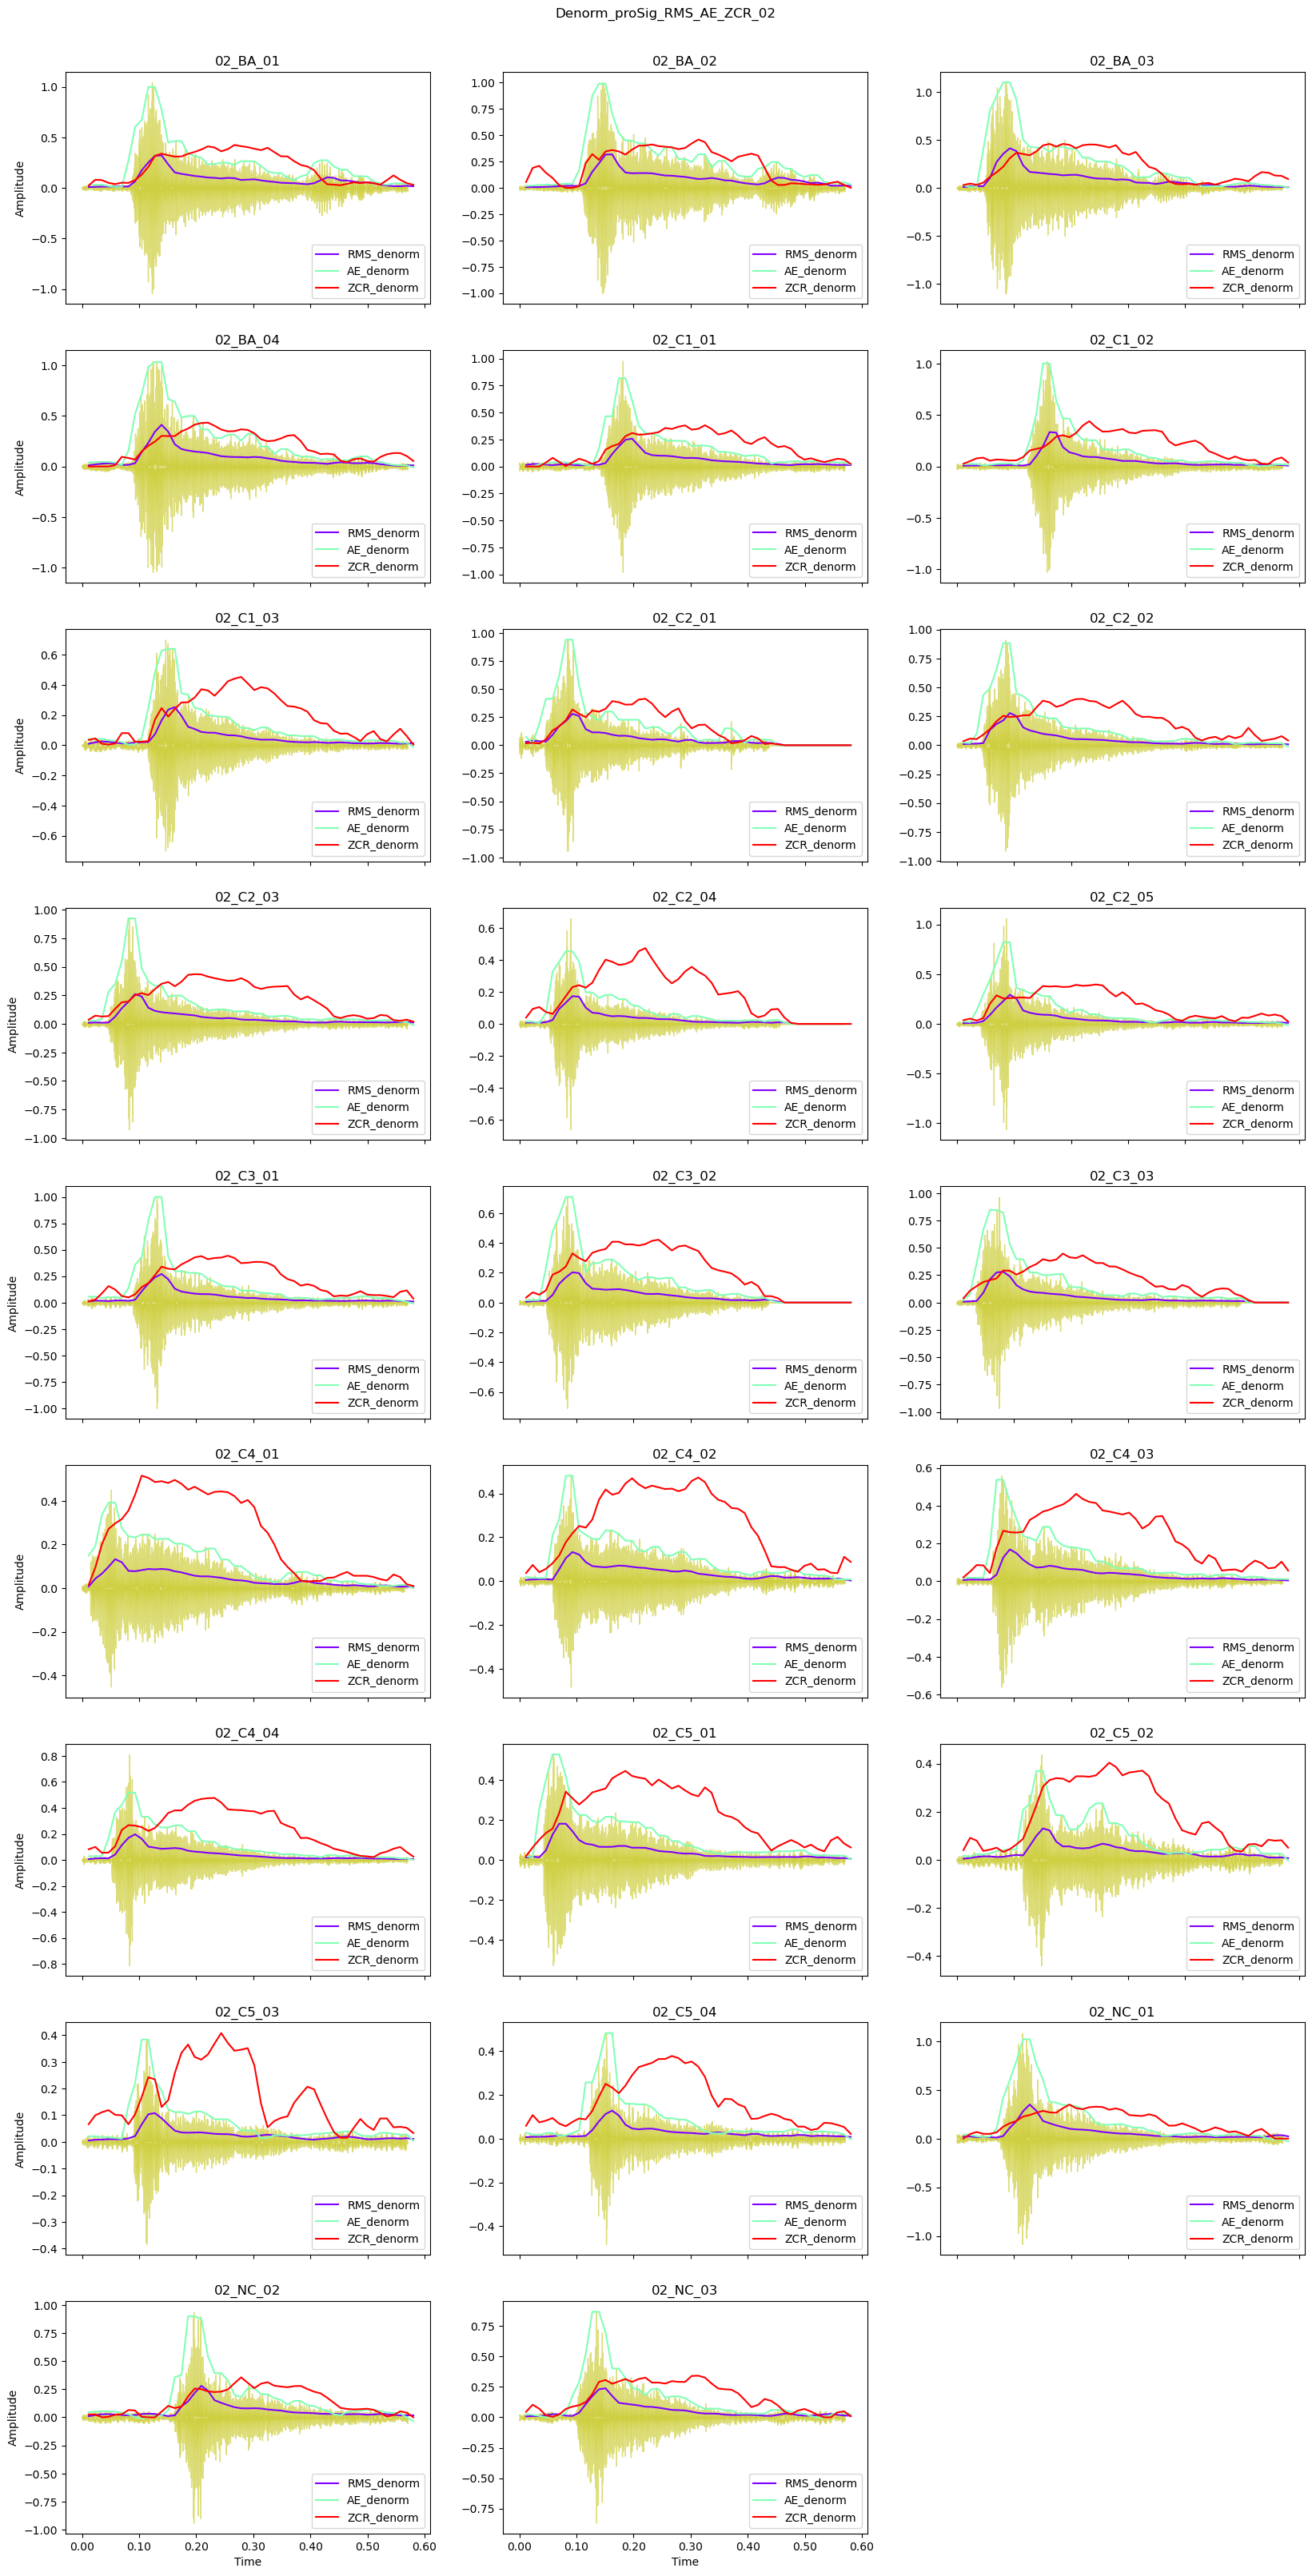

In [20]:
multi_plot_overlap_waveshow(background_signals=[denorm_processed_signals[key] for key in denorm_processed_signals.keys()
                                                if '02_' in key],
                            foreground_signals=[[denorm_rms_energies[key],
                                                 denorm_amplitude_envelopes[key],
                                                 denorm_zero_crossing_rates[key]]
                                                 for key in denorm_rms_energies.keys() if '02_' in key],
                            titles=[key for key in denorm_processed_signals.keys() if '02_' in key],
                            labels_foreground_signals=['RMS_denorm', 'AE_denorm', 'ZCR_denorm'], num_row=9, num_col=3,
                            frame_size=512, fig_size=(20, 40), suptitle='Denorm_proSig_RMS_AE_ZCR_02', x_suptitle=0.5,
                            y_suptitle=0.90, hop_length=256, color_back_sig='y', alpha_back_sig=0.5, label_outer=False)

### Spectrums

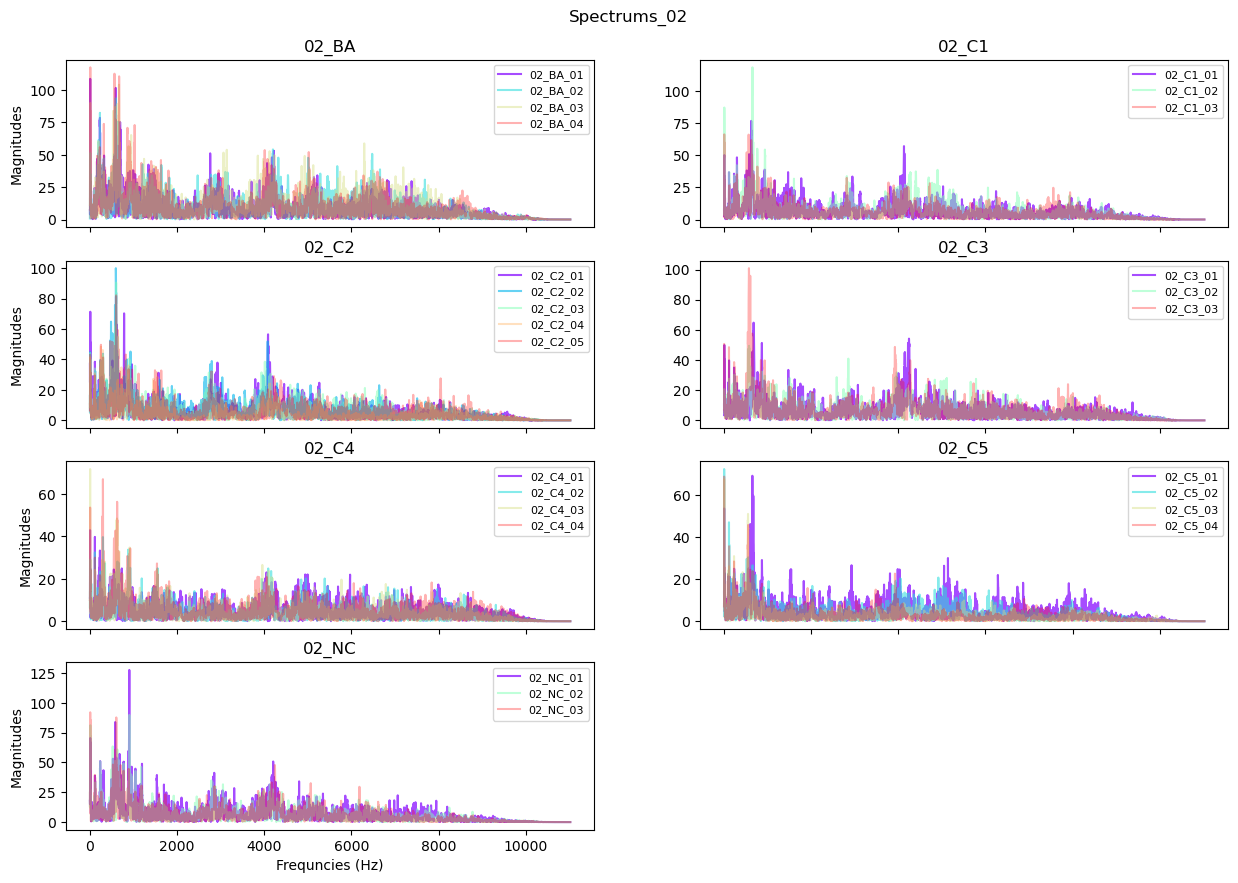

In [20]:
spectrums = multi_spectrum(signals={k:v for k, v in denorm_processed_signals.items() if '02_' in k})
multi_plot_simple(x=[[spectrums[key][0] for key in spectrums.keys() if '02_BA' in key],
                     [spectrums[key][0] for key in spectrums.keys() if '02_C1' in key],
                     [spectrums[key][0] for key in spectrums.keys() if '02_C2' in key],
                     [spectrums[key][0] for key in spectrums.keys() if '02_C3' in key],
                     [spectrums[key][0] for key in spectrums.keys() if '02_C4' in key],
                     [spectrums[key][0] for key in spectrums.keys() if '02_C5' in key],
                     [spectrums[key][0] for key in spectrums.keys() if '02_NC' in key]],
                  
                  y=[[spectrums[key][1] for key in spectrums.keys() if '02_BA' in key],
                     [spectrums[key][1] for key in spectrums.keys() if '02_C1' in key],
                     [spectrums[key][1] for key in spectrums.keys() if '02_C2' in key],
                     [spectrums[key][1] for key in spectrums.keys() if '02_C3' in key],
                     [spectrums[key][1] for key in spectrums.keys() if '02_C4' in key],
                     [spectrums[key][1] for key in spectrums.keys() if '02_C5' in key],
                     [spectrums[key][1] for key in spectrums.keys() if '02_NC' in key]],
                  
                  titles=['02_BA', '02_C1', '02_C2', '02_C3', '02_C4', '02_C5', '02_NC'],
                  
                  labels=[[key for key in spectrums.keys() if '02_BA' in key],
                          [key for key in spectrums.keys() if '02_C1' in key],
                          [key for key in spectrums.keys() if '02_C2' in key],
                          [key for key in spectrums.keys() if '02_C3' in key],
                          [key for key in spectrums.keys() if '02_C4' in key],
                          [key for key in spectrums.keys() if '02_C5' in key],
                          [key for key in spectrums.keys() if '02_NC' in key]],
                  
                  legend_fontsize=8, num_plot=7, num_row=4, num_col=2, fig_size=(15, 10), suptitle='Spectrums_02',
                  x_suptitle=0.5, y_suptitle=0.93, x_label='Frequncies (Hz)', y_label='Magnitudes', label_outer=False)

### Power Spectral Density (PSD)

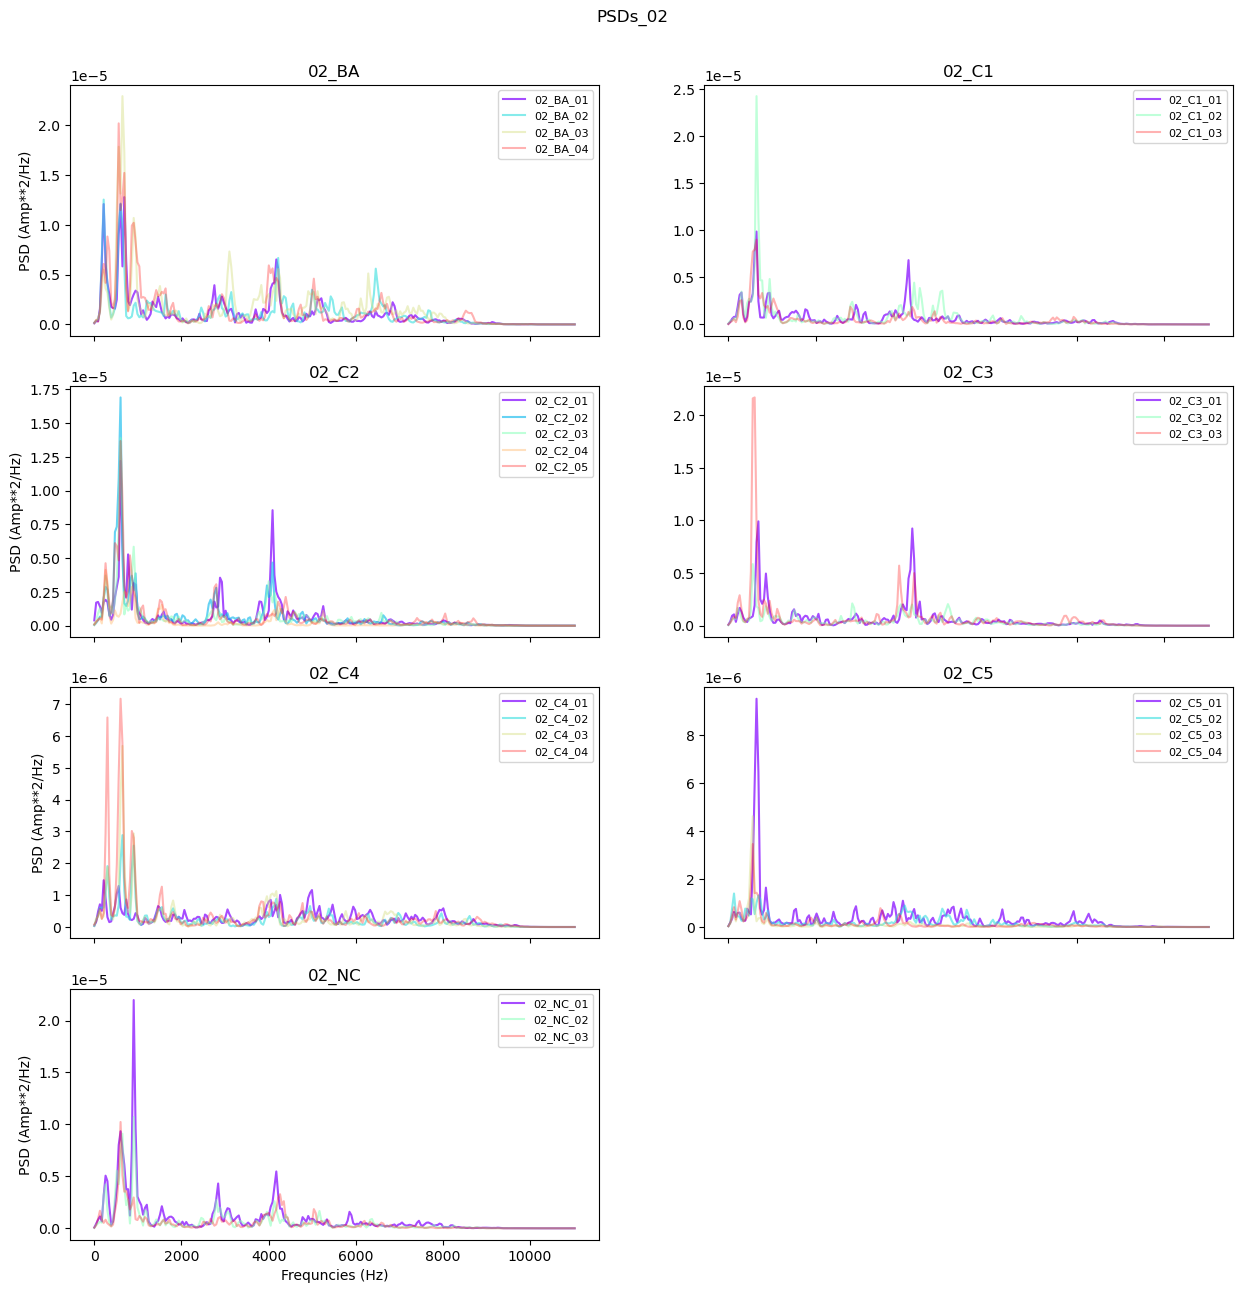

In [16]:
psds = multi_psd(signals={k:v for k, v in denorm_processed_signals.items() if '02_' in k},
                 sr=22050, nperseg=512, noverlap=256, nfft=512, scaling='density')
multi_plot_simple(x=[[psds[key][0] for key in psds.keys() if '02_BA' in key],
                     [psds[key][0] for key in psds.keys() if '02_C1' in key],
                     [psds[key][0] for key in psds.keys() if '02_C2' in key],
                     [psds[key][0] for key in psds.keys() if '02_C3' in key],
                     [psds[key][0] for key in psds.keys() if '02_C4' in key],
                     [psds[key][0] for key in psds.keys() if '02_C5' in key],
                     [psds[key][0] for key in psds.keys() if '02_NC' in key]],
                  
                  y=[[psds[key][1] for key in psds.keys() if '02_BA' in key],
                     [psds[key][1] for key in psds.keys() if '02_C1' in key],
                     [psds[key][1] for key in psds.keys() if '02_C2' in key],
                     [psds[key][1] for key in psds.keys() if '02_C3' in key],
                     [psds[key][1] for key in psds.keys() if '02_C4' in key],
                     [psds[key][1] for key in psds.keys() if '02_C5' in key],
                     [psds[key][1] for key in psds.keys() if '02_NC' in key]],
                  
                  titles=['02_BA', '02_C1', '02_C2', '02_C3', '02_C4', '02_C5', '02_NC'],
                  
                  labels=[[key for key in psds.keys() if '02_BA' in key],
                          [key for key in psds.keys() if '02_C1' in key],
                          [key for key in psds.keys() if '02_C2' in key],
                          [key for key in psds.keys() if '02_C3' in key],
                          [key for key in psds.keys() if '02_C4' in key],
                          [key for key in psds.keys() if '02_C5' in key],
                          [key for key in psds.keys() if '02_NC' in key]],
                  
                  log_axis=None, legend_fontsize=8, num_plot=7, num_row=4, num_col=2, fig_size=(15, 15),
                  suptitle='PSDs_02', label_loc='upper right', x_suptitle=0.5, y_suptitle=0.93, x_label='Frequncies (Hz)',
                  y_label='PSD (Amp**2/Hz)', label_outer=False)

### ZCR-AE Difference

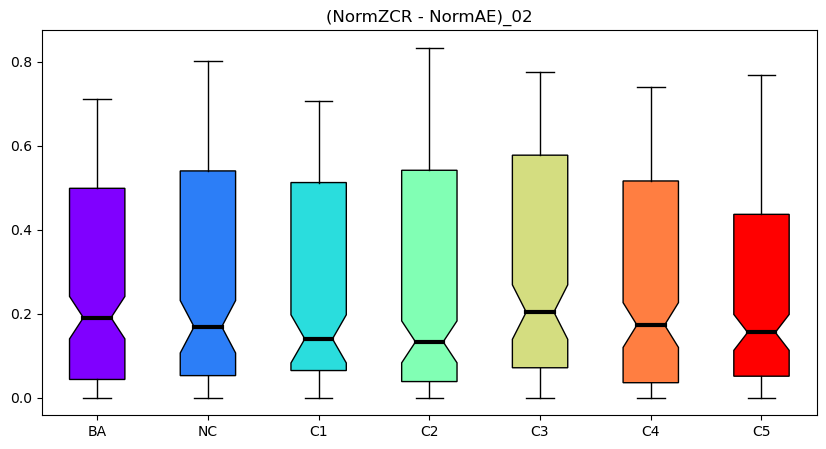

In [29]:
multi_plot_box(signals=[[delta_zcr_ae(key, 5, (True, True)) for key in denorm_rms_energies.keys() if '02_BA' in key],
                        [delta_zcr_ae(key, 5, (True, True)) for key in denorm_rms_energies.keys() if '02_NC' in key],
                        [delta_zcr_ae(key, 5, (True, True)) for key in denorm_rms_energies.keys() if '02_C1' in key],
                        [delta_zcr_ae(key, 5, (True, True)) for key in denorm_rms_energies.keys() if '02_C2' in key],
                        [delta_zcr_ae(key, 5, (True, True)) for key in denorm_rms_energies.keys() if '02_C3' in key],
                        [delta_zcr_ae(key, 5, (True, True)) for key in denorm_rms_energies.keys() if '02_C4' in key],
                        [delta_zcr_ae(key, 5, (True, True)) for key in denorm_rms_energies.keys() if '02_C5' in key]],
                                      
               titles=['(NormZCR - NormAE)_02'],
              
               labels=['BA', 'NC', 'C1', 'C2', 'C3', 'C4', 'C5'],
              
               num_row=1, num_col=1, fig_size=(10, 5), suptitle=None, x_suptitle=0.5, y_suptitle=0.92,
               y_label=None, label_outer=True, vert=True, patch_artist=True, notch=True, median_color='black')

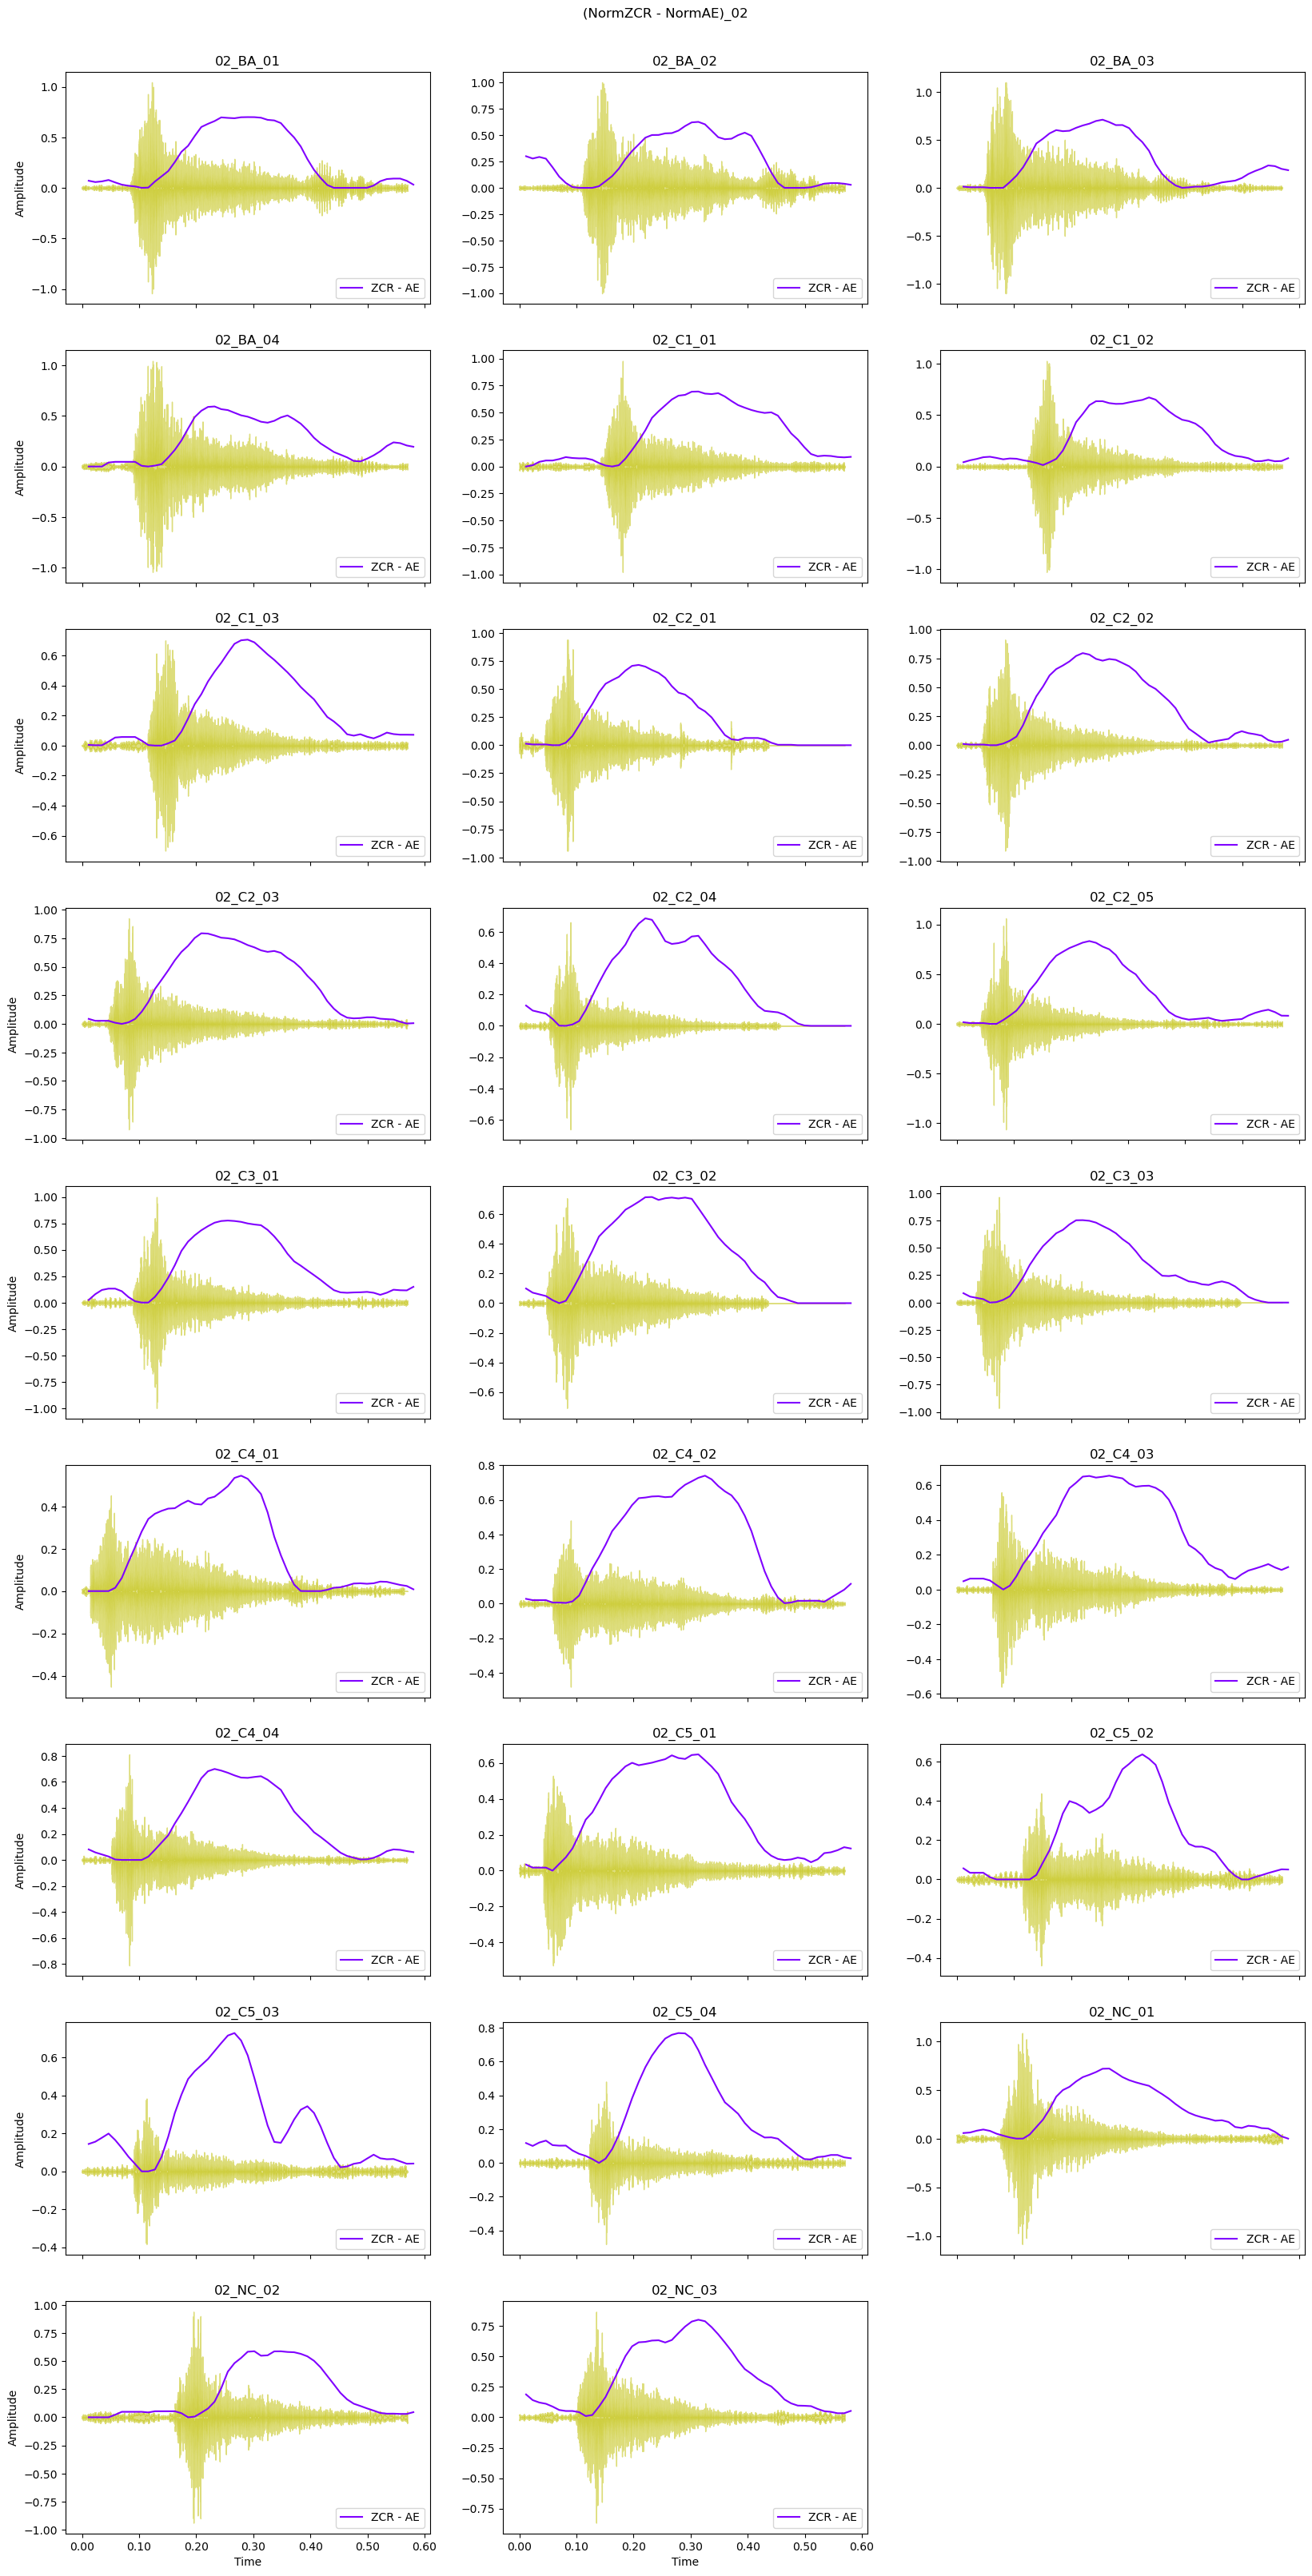

In [30]:
multi_plot_overlap_waveshow(background_signals=[denorm_processed_signals[key] for key in denorm_processed_signals.keys()
                                                if '02_' in key],
                            foreground_signals=[[delta_zcr_ae(key, 5, (True, True))]
                                                 for key in denorm_rms_energies.keys() if '02_' in key],
                            titles=[key for key in denorm_processed_signals.keys() if '02_' in key],
                            labels_foreground_signals=['ZCR - AE'], num_row=9, num_col=3,
                            frame_size=512, fig_size=(20, 40), suptitle='(NormZCR - NormAE)_02', x_suptitle=0.5,
                            y_suptitle=0.90, hop_length=256, color_back_sig='y', alpha_back_sig=0.5, label_outer=False)

### AUCs

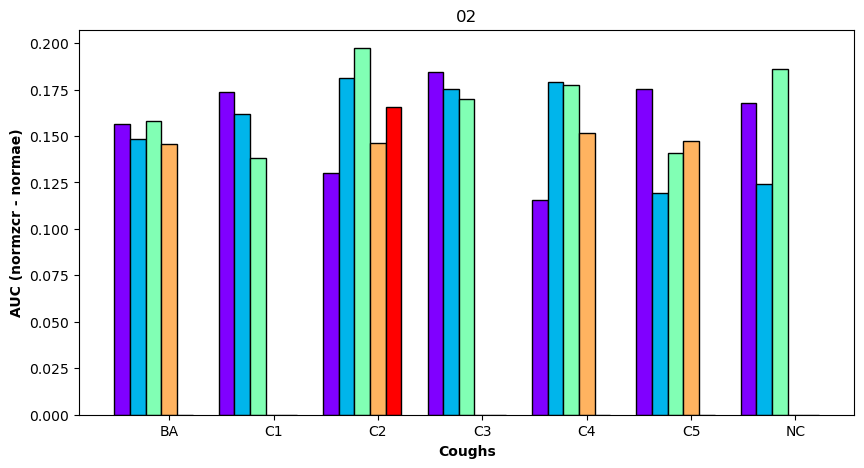

In [16]:
multi_plot_bar(heights=[[auc_delta_zcr_ae(key, 5, (True, True)) for key in zero_crossing_rates.keys() if '02_BA' in key],
                        [auc_delta_zcr_ae(key, 5, (True, True)) for key in zero_crossing_rates.keys() if '02_C1' in key],
                        [auc_delta_zcr_ae(key, 5, (True, True)) for key in zero_crossing_rates.keys() if '02_C2' in key],
                        [auc_delta_zcr_ae(key, 5, (True, True)) for key in zero_crossing_rates.keys() if '02_C3' in key],
                        [auc_delta_zcr_ae(key, 5, (True, True)) for key in zero_crossing_rates.keys() if '02_C4' in key],
                        [auc_delta_zcr_ae(key, 5, (True, True)) for key in zero_crossing_rates.keys() if '02_C5' in key],
                        [auc_delta_zcr_ae(key, 5, (True, True)) for key in zero_crossing_rates.keys() if '02_NC' in key]],
               bars=['BA', 'C1', 'C2', 'C3', 'C4', 'C5', 'NC'],
               titles=['02'],
               num_plot=1, num_row=1, num_col=1, bar_width=0.15, intra_width=0.15, edge_color='black', fig_size=(10, 5),
               x_label='Coughs', y_label='AUC (normzcr - normae)',  label_fontsize=10, label_fontweight='bold',
               suptitle=None, x_suptitle=0.5, y_suptitle=0.92, label_outer=True)

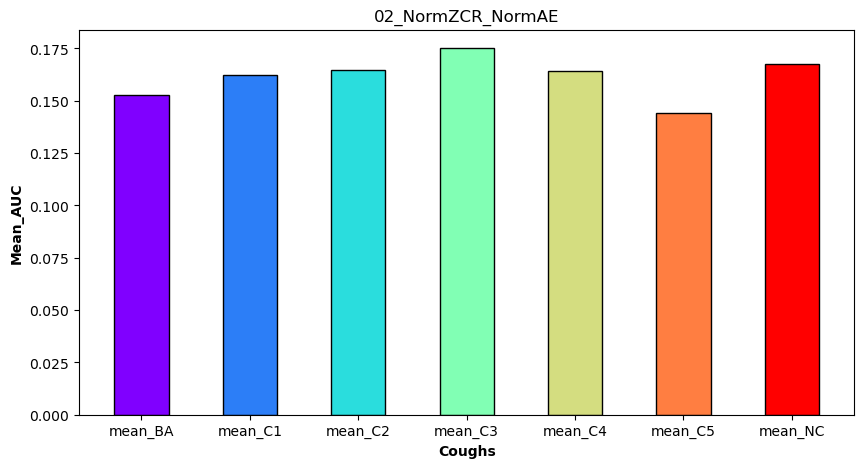

In [28]:
multi_plot_bar(heights=[mean_percentile([auc_delta_zcr_ae(key, 5, (True, True)) for key in zero_crossing_rates.keys()
                                         if '02_BA' in key], 20, 80),
                        mean_percentile([auc_delta_zcr_ae(key, 5, (True, True)) for key in zero_crossing_rates.keys()
                                         if '02_C1' in key], 20, 80),
                        mean_percentile([auc_delta_zcr_ae(key, 5, (True, True)) for key in zero_crossing_rates.keys()
                                         if '02_C2' in key], 20, 80),
                        mean_percentile([auc_delta_zcr_ae(key, 5, (True, True)) for key in zero_crossing_rates.keys()
                                         if '02_C3' in key], 20, 80),
                        mean_percentile([auc_delta_zcr_ae(key, 5, (True, True)) for key in zero_crossing_rates.keys()
                                         if '02_C4' in key], 20, 80),
                        mean_percentile([auc_delta_zcr_ae(key, 5, (True, True)) for key in zero_crossing_rates.keys()
                                         if '02_C5' in key], 20, 80),
                        mean_percentile([auc_delta_zcr_ae(key, 5, (True, True)) for key in zero_crossing_rates.keys()
                                         if '02_NC' in key], 20, 80)],
               bars=['mean_BA', 'mean_C1', 'mean_C2', 'mean_C3', 'mean_C4', 'mean_C5', 'mean_NC'],
               titles=['02_NormZCR_NormAE'],
               num_plot=1, num_row=1, num_col=1, bar_width=.5, intra_width=.5, edge_color='black',
               fig_size=(10, 5), x_label='Coughs', y_label='Mean_AUC', suptitle=None, x_suptitle=0.5,
               y_suptitle=0.92,  label_fontsize=10, label_fontweight='bold', label_outer=True)

### ZCR-AE Correlation Coefficient

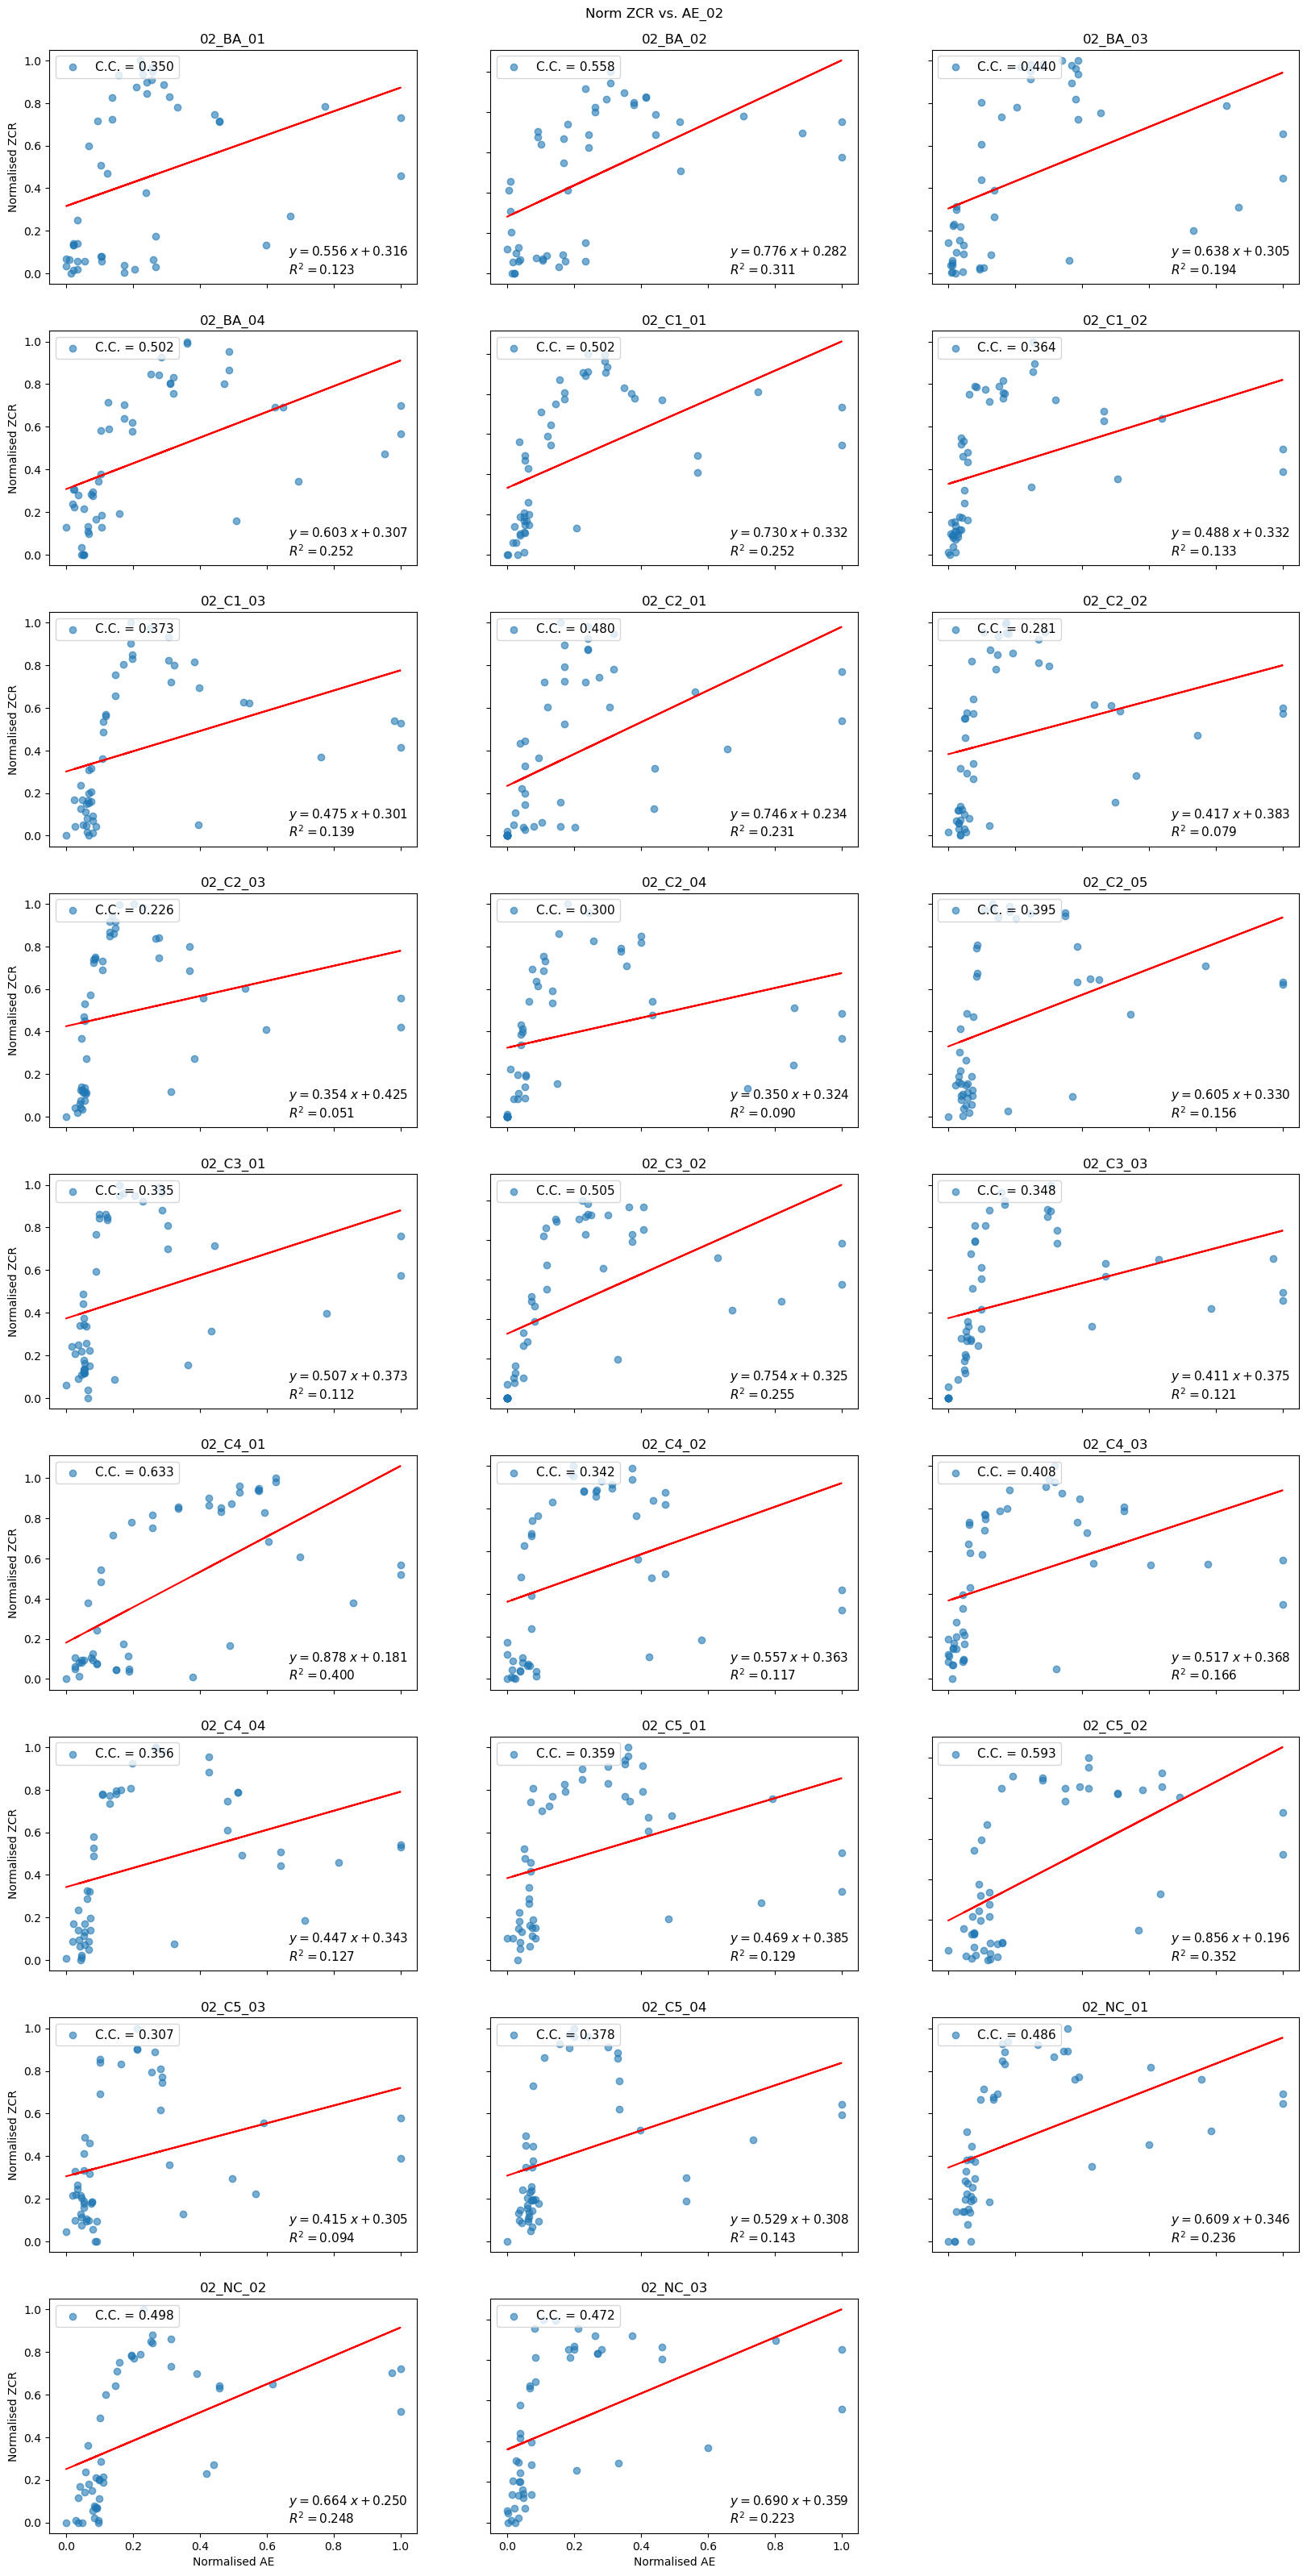

In [27]:
multi_plot_scatter(x = [[amplitude_envelopes[key]] for key in amplitude_envelopes.keys() if '02_' in key],
                   y = [[zero_crossing_rates[key]] for key in amplitude_envelopes.keys() if '02_' in key],
                   titles = [key for key in amplitude_envelopes.keys() if '02_' in key],
                   labels = ['C.C.'] * 26, points_alpha=0.6, x_text=0.65, y_text=0.17,
                   num_plot=26, num_row=9, num_col=3, polynomial=True, poly_deg=1, label_fontsize=11, label_cols=1,
                   label_loc='upper left', fig_size=(20, 40), suptitle='Norm ZCR vs. AE_02', x_suptitle=0.5,
                   y_suptitle=0.893, x_label='Normalised AE', y_label='Normalised ZCR', label_outer=True)

### Cumsums of ZCR and Amplitudes

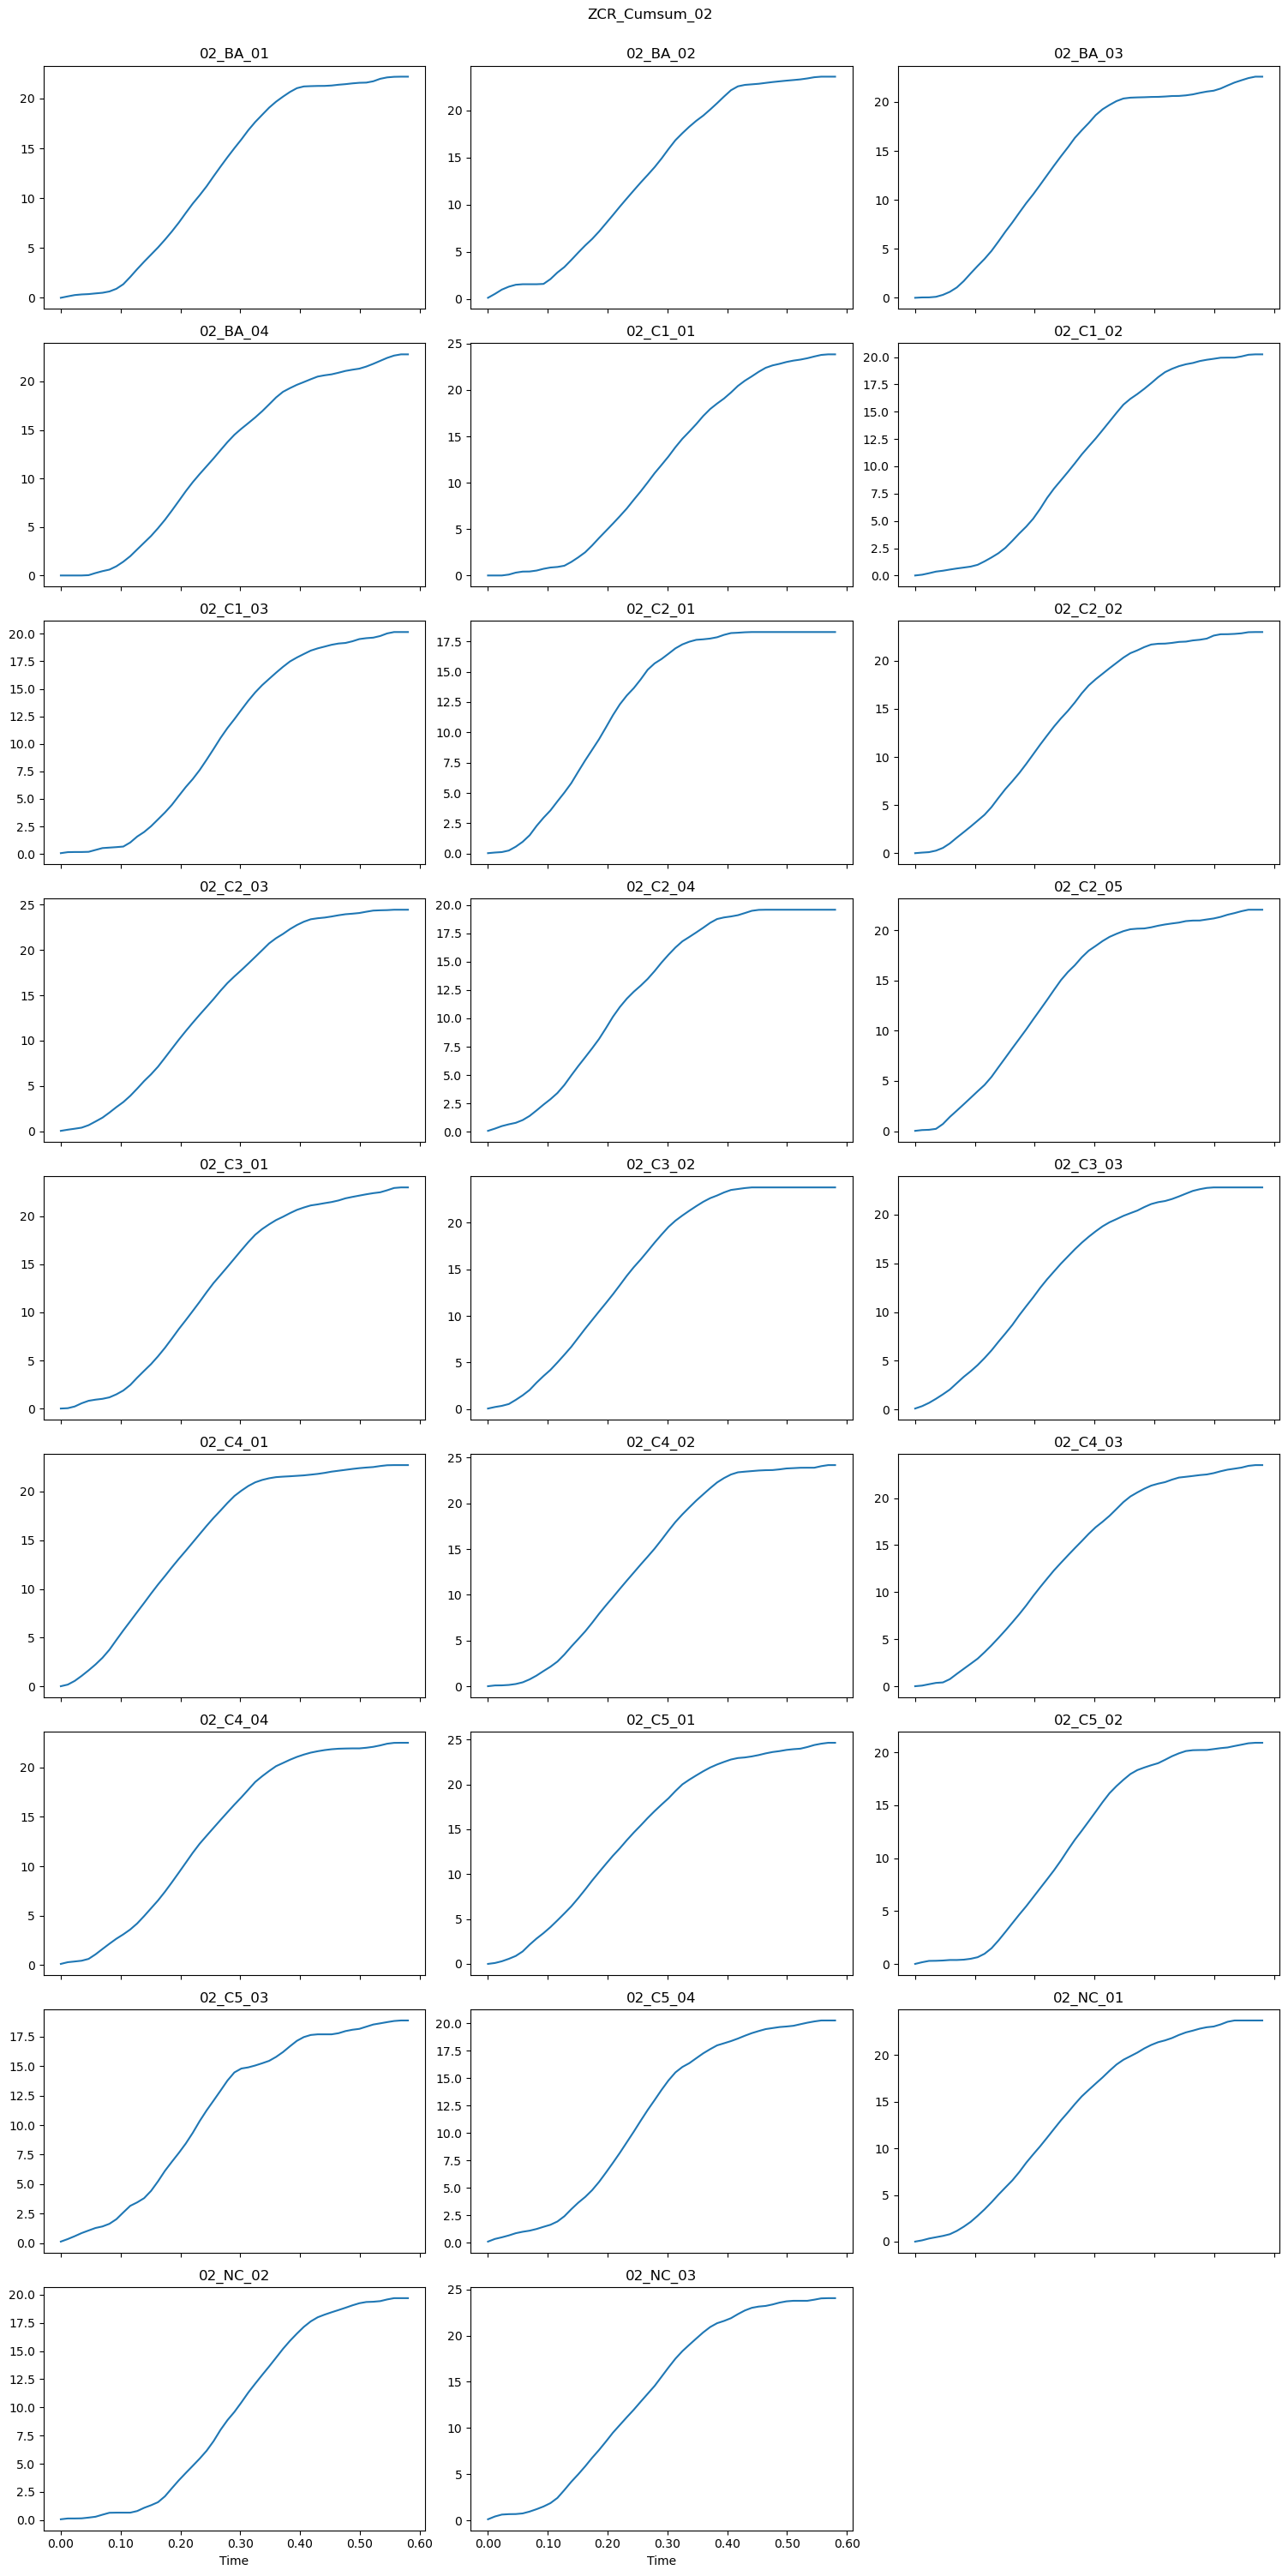

In [19]:
multi_plot_spectral([np.cumsum(zero_crossing_rates[key]) for key in zero_crossing_rates.keys() if '02_' in key], 
                    [key for key in zero_crossing_rates.keys() if '02_' in key],
                    num_row=9, num_col=3, fig_size=(15, 30), suptitle='ZCR_Cumsum_02',
                    x_suptitle=0.5, y_suptitle=1, label_outer=False, hop_length=256)

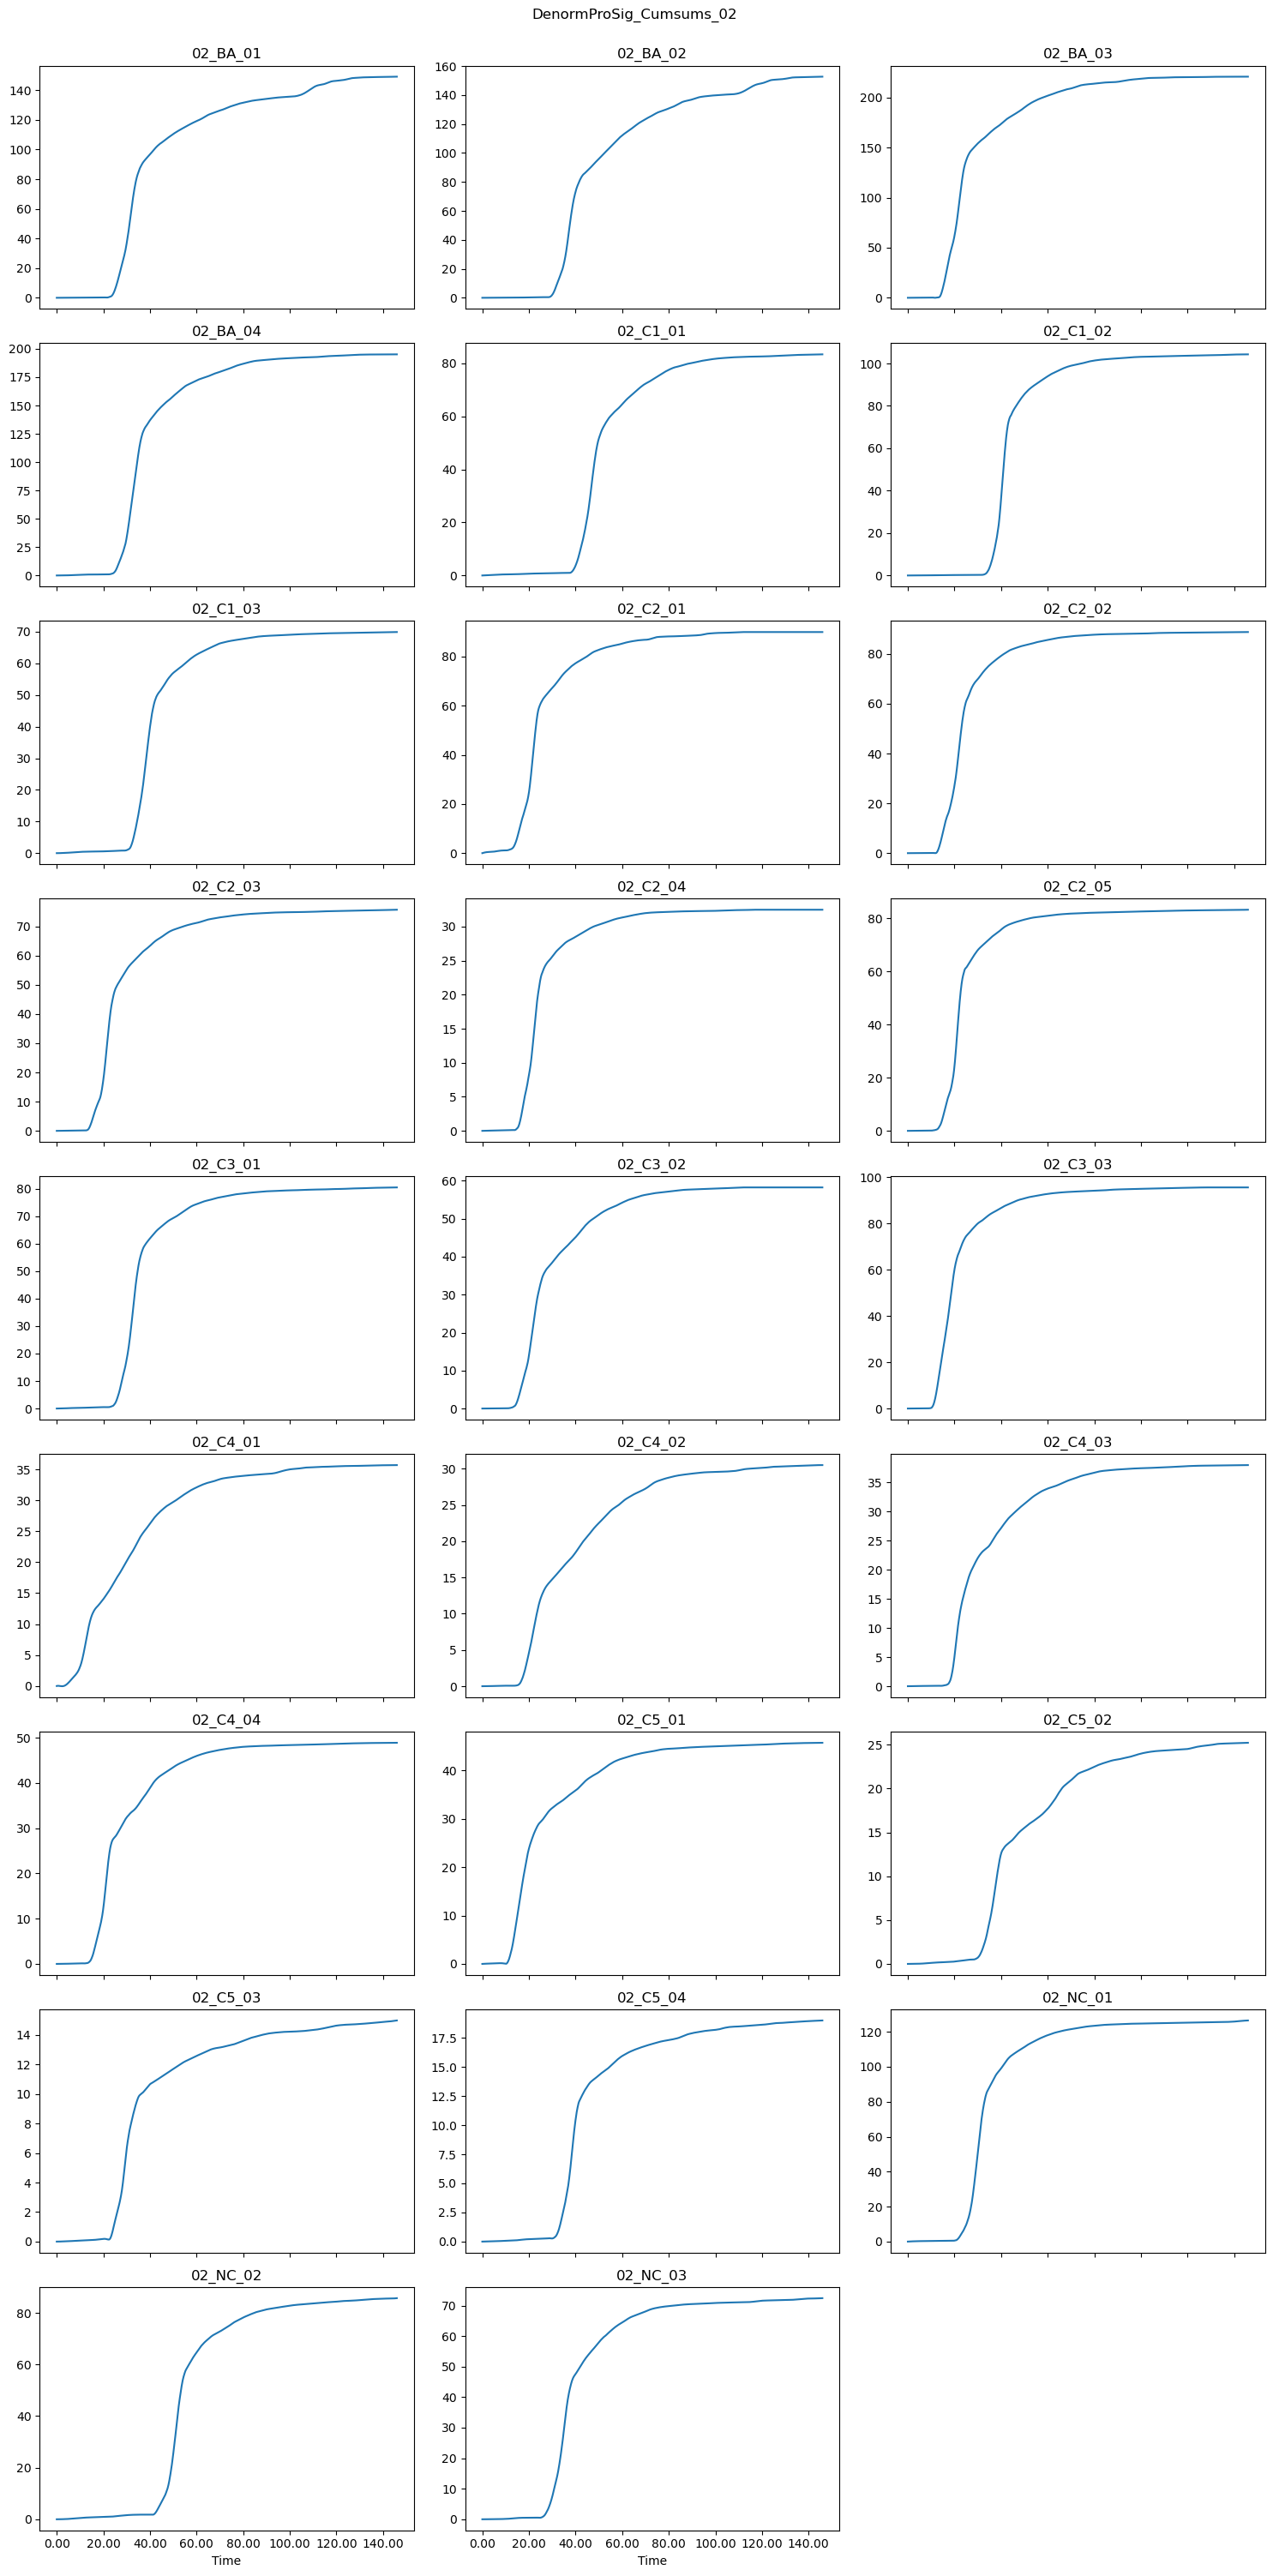

In [18]:
multi_plot_spectral([denorm_filtered_squared_cumsums[key] for key in denorm_filtered_squared_cumsums.keys()
                     if '02_' in key], 
                    [key for key in denorm_filtered_squared_cumsums.keys() if '02_' in key],
                    num_row=9, num_col=3, fig_size=(15, 30), suptitle='DenormProSig_Cumsums_02',
                    x_suptitle=0.5, y_suptitle=1, label_outer=False, hop_length=256)

In [14]:
corr_coeffs_ZCR_AE = {}
for key in [key for key in amplitude_envelopes.keys() if '02_' in key]:
    corr_coeffs_ZCR_AE[key] = round(np.corrcoef(amplitude_envelopes[key], zero_crossing_rates[key])[0, 1], 2)

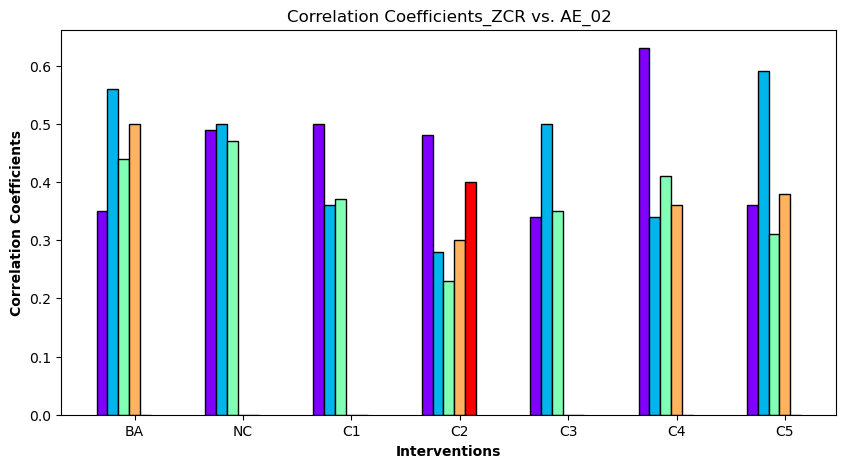

In [23]:
multi_plot_bar(heights=[[corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_BA' in key],
                        [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_NC' in key],
                        [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_C1' in key],
                        [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_C2' in key],
                        [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_C3' in key],
                        [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_C4' in key],
                        [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_C5' in key]],
               bars=['BA', 'NC', 'C1', 'C2', 'C3', 'C4', 'C5'],
               titles=['Correlation Coefficients_ZCR vs. AE_02'],
               num_plot=1, num_row=1, num_col=1, bar_width=0.1, intra_width=0.1, edge_color='black', fig_size=(10, 5),
               x_label='Interventions', y_label='Correlation Coefficients',  label_fontsize=10, label_fontweight='bold',
               suptitle=None, x_suptitle=0.5, y_suptitle=0.92, label_outer=True)

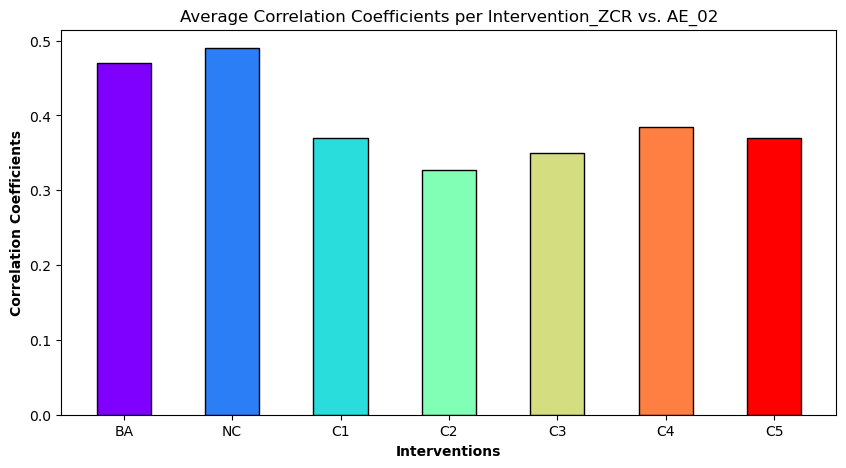

In [29]:
multi_plot_bar(heights=[mean_percentile([corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys()
                                         if '02_BA' in key], 10, 90),
                        mean_percentile([corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys()
                                         if '02_NC' in key], 10, 90),
                        mean_percentile([corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys()
                                         if '02_C1' in key], 10, 90),
                        mean_percentile([corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys()
                                         if '02_C2' in key], 10, 90),
                        mean_percentile([corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys()
                                         if '02_C3' in key], 10, 90),
                        mean_percentile([corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys()
                                         if '02_C4' in key], 10, 90),
                        mean_percentile([corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys()
                                         if '02_C5' in key], 10, 90)],
               bars=['BA', 'NC', 'C1', 'C2', 'C3', 'C4', 'C5'],
               titles=['Average Correlation Coefficients per Intervention_ZCR vs. AE_02'],
               num_plot=1, num_row=1, num_col=1, bar_width=.5, intra_width=.5, edge_color='black',
               fig_size=(10, 5), x_label='Interventions', y_label='Correlation Coefficients', suptitle=None,
               x_suptitle=0.5, y_suptitle=0.92,  label_fontsize=10, label_fontweight='bold', label_outer=True)

In [30]:
np.var([mean_percentile([corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys()
                                         if '02_BA' in key], 10, 90),
                        mean_percentile([corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys()
                                         if '02_NC' in key], 10, 90),
                        mean_percentile([corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys()
                                         if '02_C1' in key], 10, 90),
                        mean_percentile([corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys()
                                         if '02_C2' in key], 10, 90),
                        mean_percentile([corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys()
                                         if '02_C3' in key], 10, 90),
                        mean_percentile([corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys()
                                         if '02_C4' in key], 10, 90),
                        mean_percentile([corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys()
                                         if '02_C5' in key], 10, 90)])

0.0032418367346938766

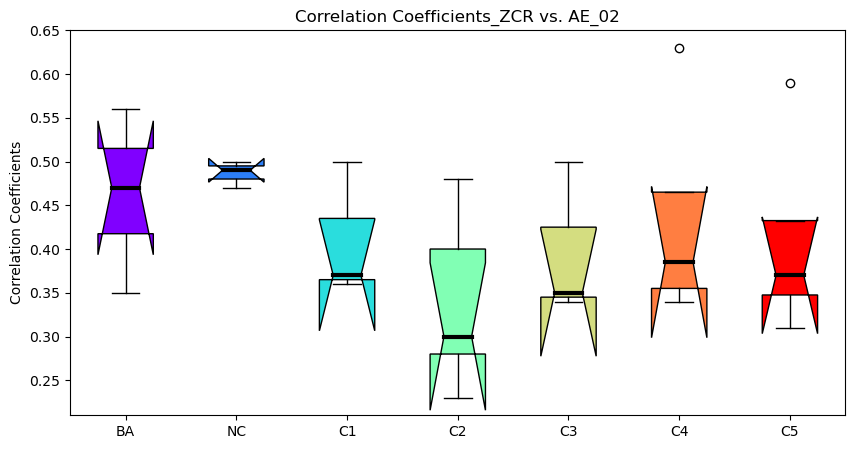

In [18]:
multi_plot_box(signals=[[corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_BA' in key],
                        [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_NC' in key],
                        [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_C1' in key],
                        [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_C2' in key],
                        [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_C3' in key],
                        [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_C4' in key],
                        [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_C5' in key]],
                                      
               titles=['Correlation Coefficients_ZCR vs. AE_02'],
              
               labels=['BA', 'NC', 'C1', 'C2', 'C3', 'C4', 'C5'],
              
               num_row=1, num_col=1, fig_size=(10, 5), suptitle=None, x_suptitle=0.5, y_suptitle=0.92,
               y_label='Correlation Coefficients', label_outer=True, vert=True, patch_artist=True, notch=True, median_color='black')

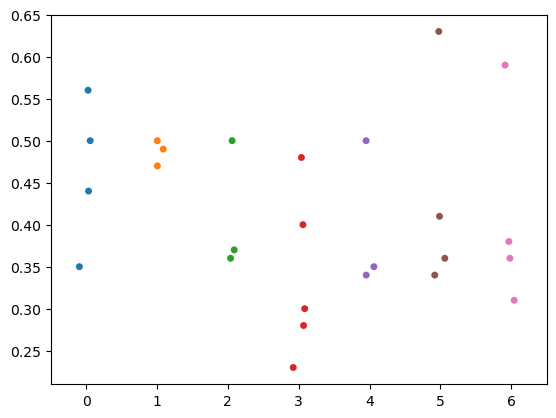

In [16]:
from seaborn import stripplot
stripplot(data=[[corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_BA' in key],
                [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_NC' in key],
                [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_C1' in key],
                [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_C2' in key],
                [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_C3' in key],
                [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_C4' in key],
                [corr_coeffs_ZCR_AE[key] for key in corr_coeffs_ZCR_AE.keys() if '02_C5' in key]])
plt.show()

### Spectral Features
**Spectral Centroid**: indicates in which frequency band at each moment the most energy is concentrated

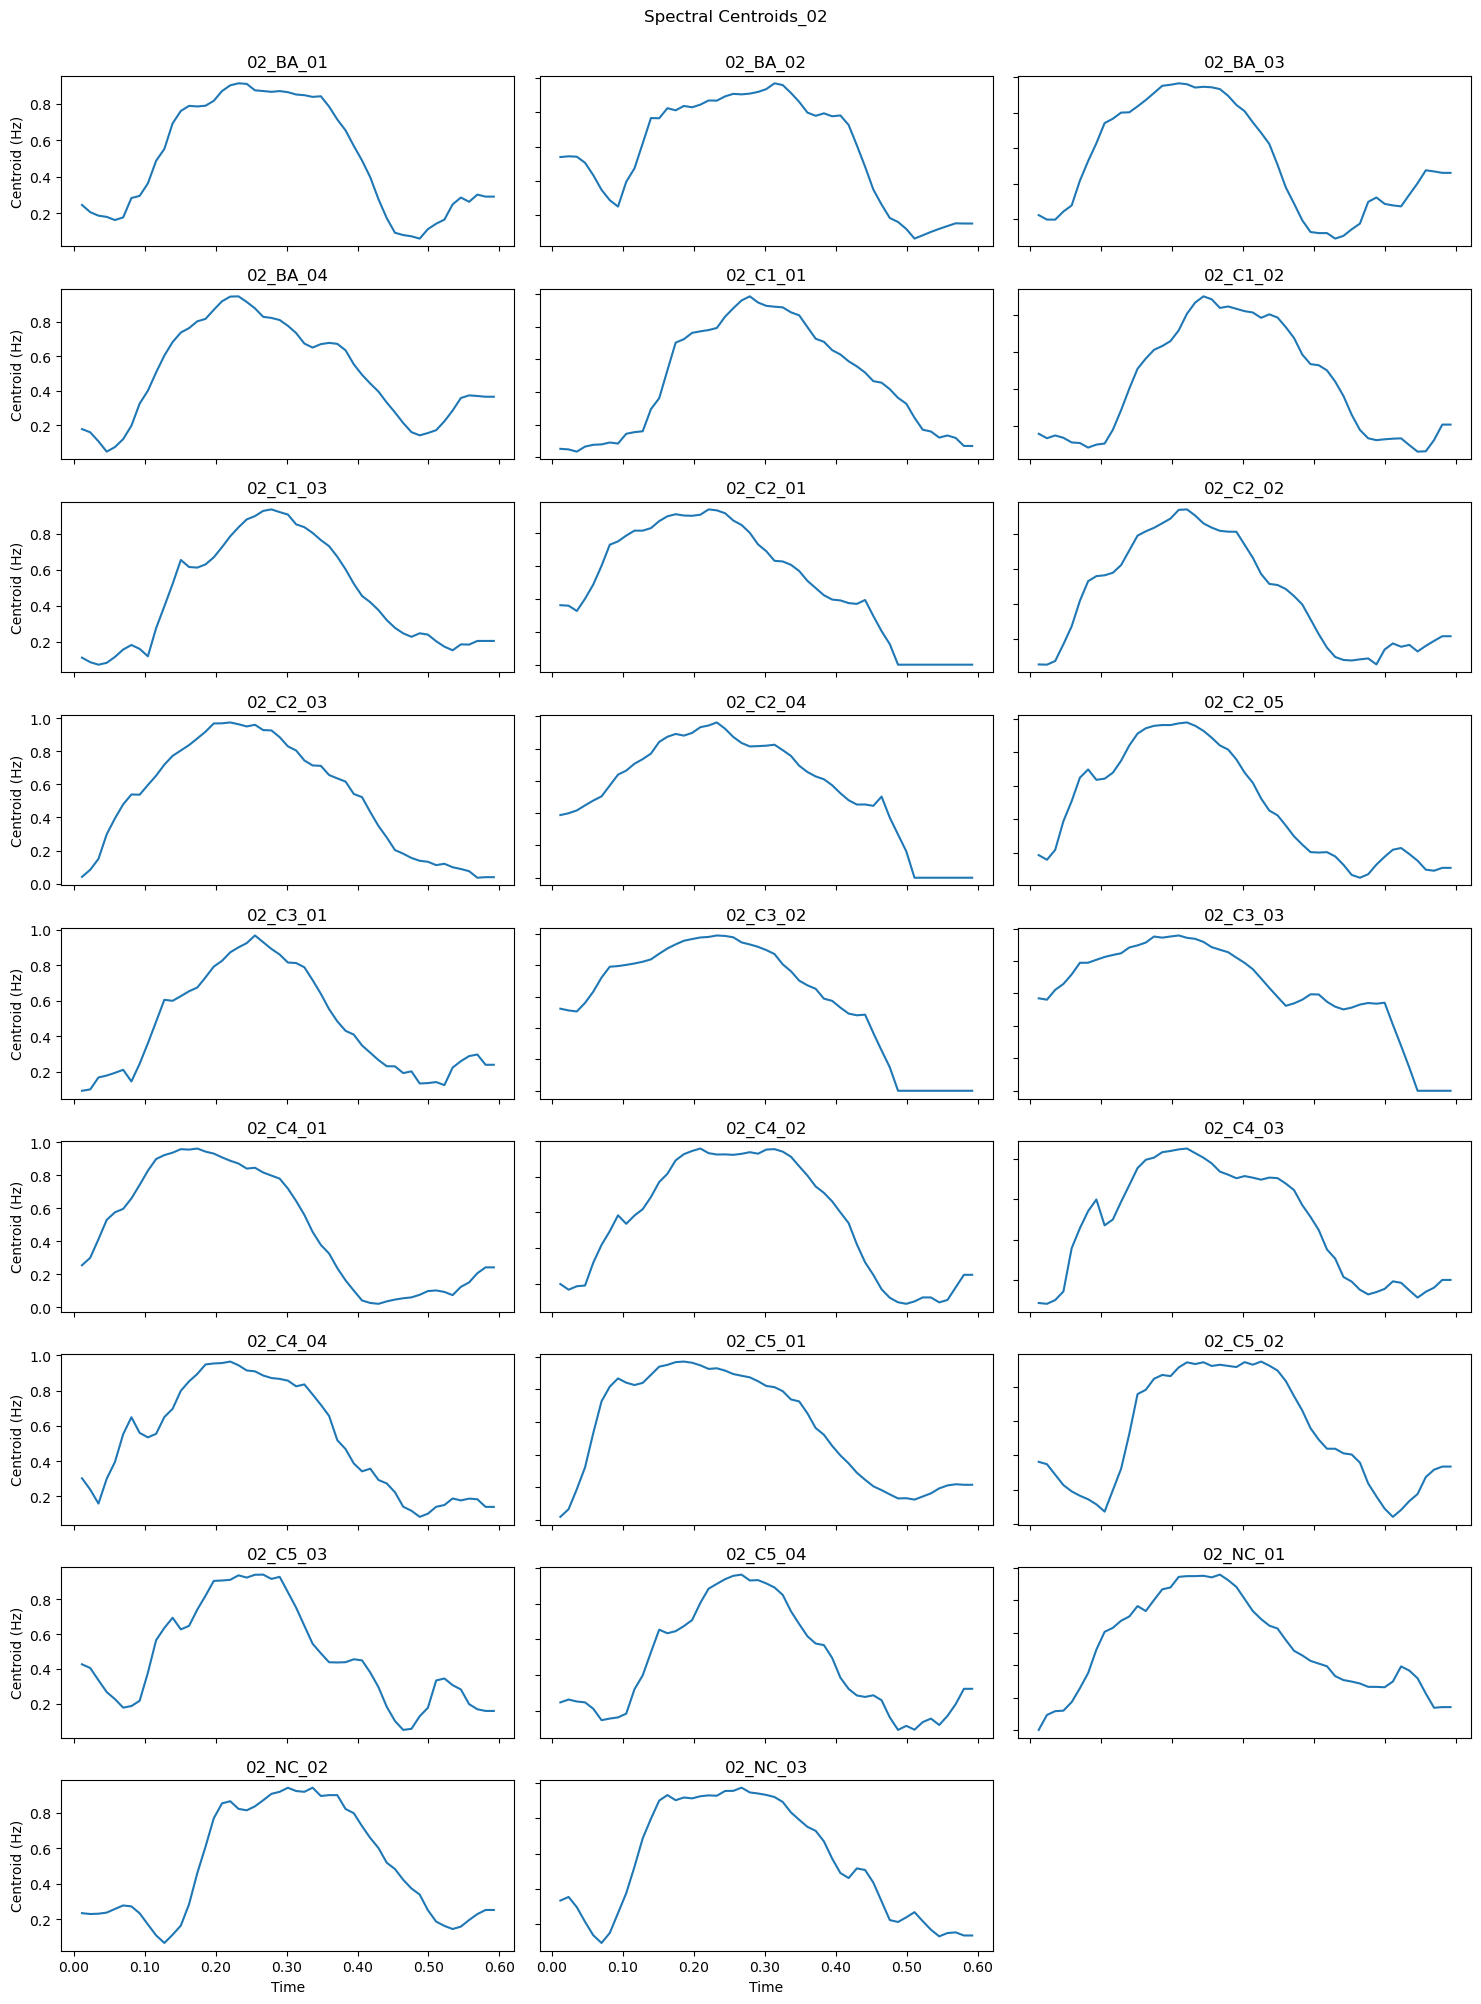

In [19]:
multi_plot_spectral(signals=[uniform_filter1d(spectral_centroids[key], 4) for key in spectral_centroids if '02_' in key],
                    titles=[key for key in spectral_centroids.keys() if '02_' in key], num_row=9, num_col=3,
                    fig_size=(15, 20), y_label='Centroid (Hz)', label_outer=True, suptitle='Spectral Centroids_02',
                    x_suptitle=0.5, y_suptitle=1, sample_rate=22050, frame_size=512, hop_length=256)

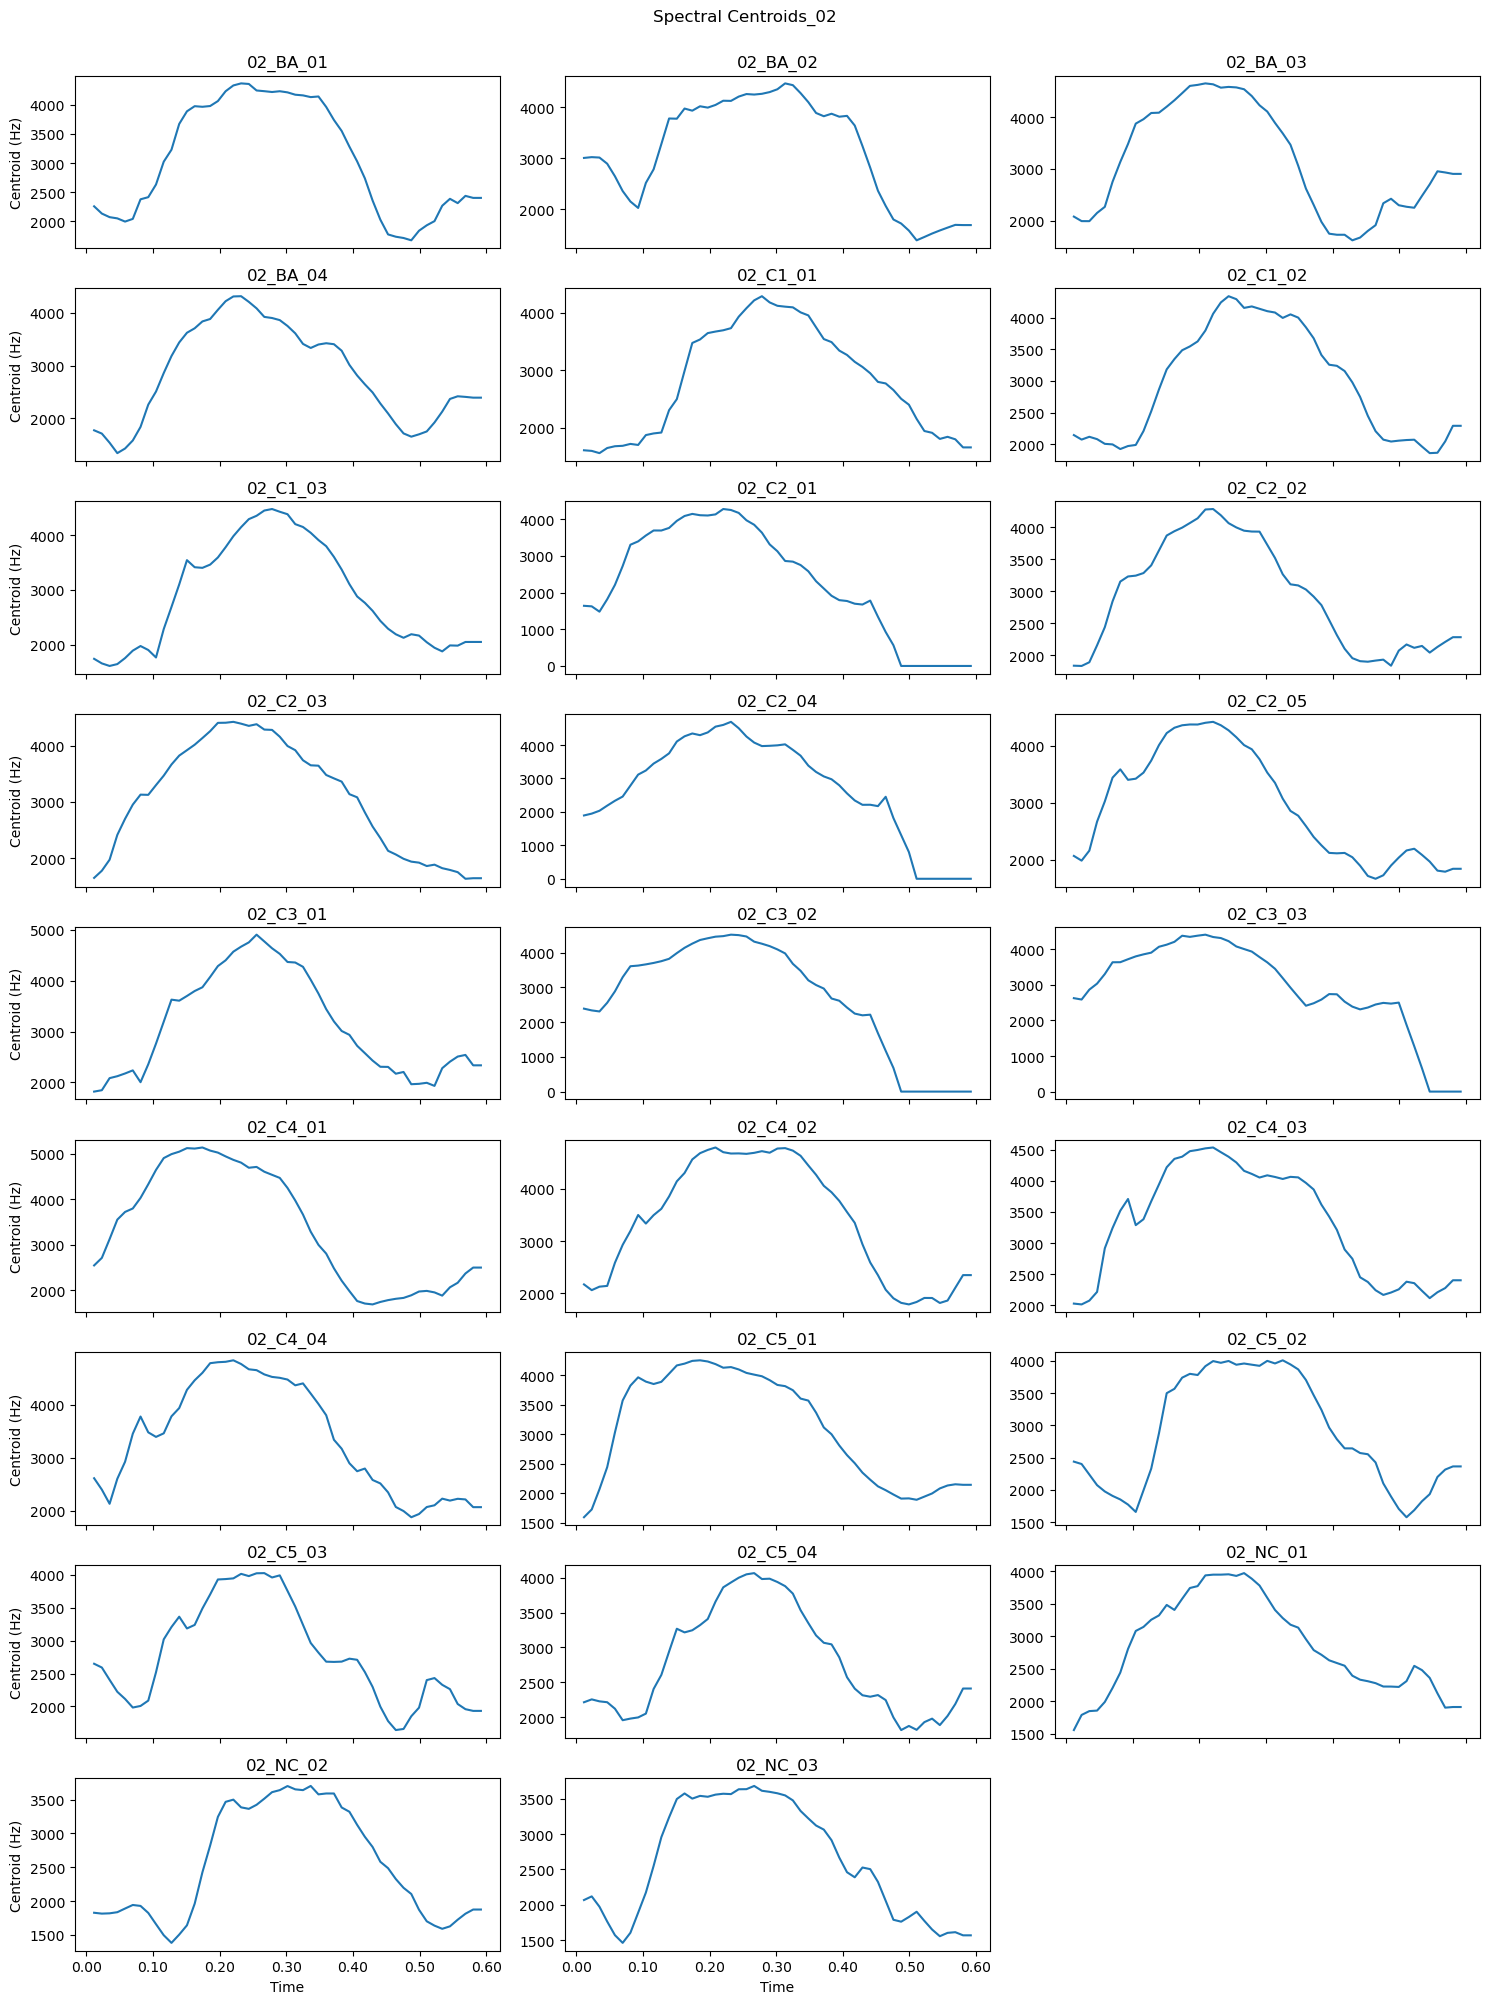

In [20]:
multi_plot_spectral(signals=[uniform_filter1d(denorm_spectral_centroids[key], 4) for key in spectral_centroids if '02_' in key],
                    titles=[key for key in spectral_centroids.keys() if '02_' in key], num_row=9, num_col=3,
                    fig_size=(15, 20), y_label='Centroid (Hz)', label_outer=False, suptitle='Spectral Centroids_02',
                    x_suptitle=0.5, y_suptitle=1, sample_rate=22050, frame_size=512, hop_length=256)

**Spectral Bandwidth**: indicates the difference between the upper and lower frequencies in a continuous band of frequencies

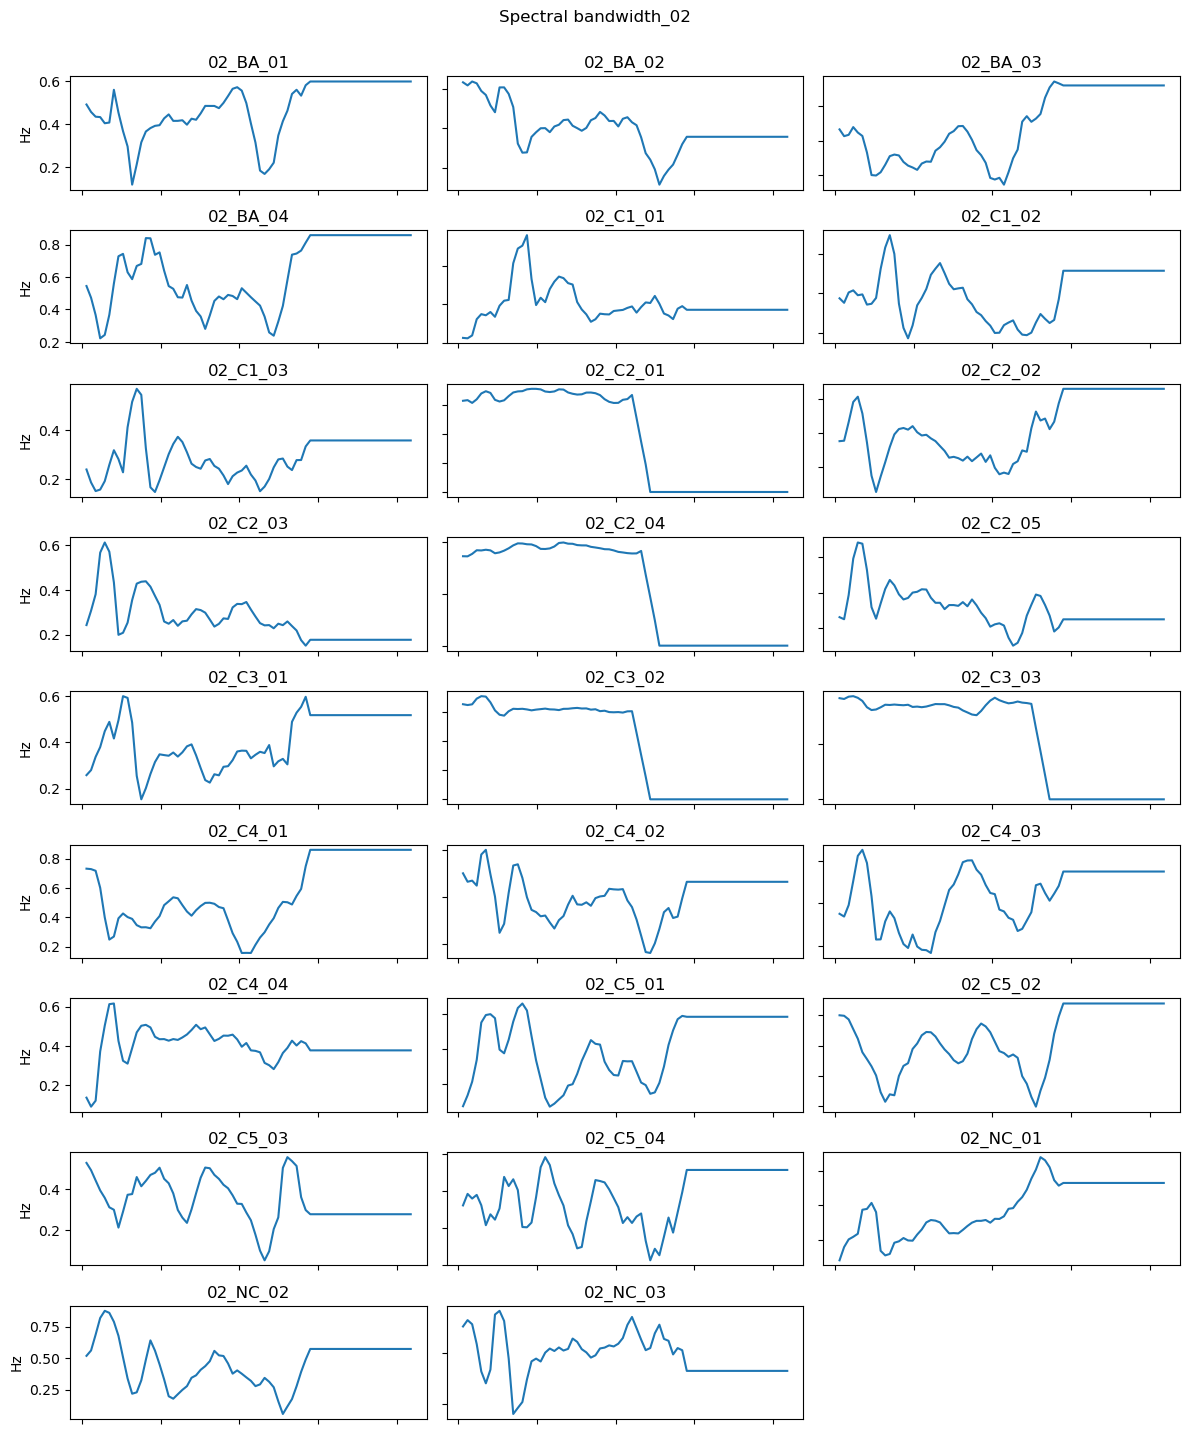

In [21]:
multi_plot_spectral(signals=[uniform_filter1d(spectral_bandwidths[key], 4) for key in spectral_bandwidths if '02_' in key],
                    titles=[key for key in spectral_bandwidths.keys() if '02_' in key], num_row=16, num_col=3,
                    fig_size=(12, 25), y_label='Hz', label_outer=True, suptitle='Spectral bandwidth_02',
                    x_suptitle=0.5, y_suptitle=1, sample_rate=22050, frame_size=512, hop_length=256)

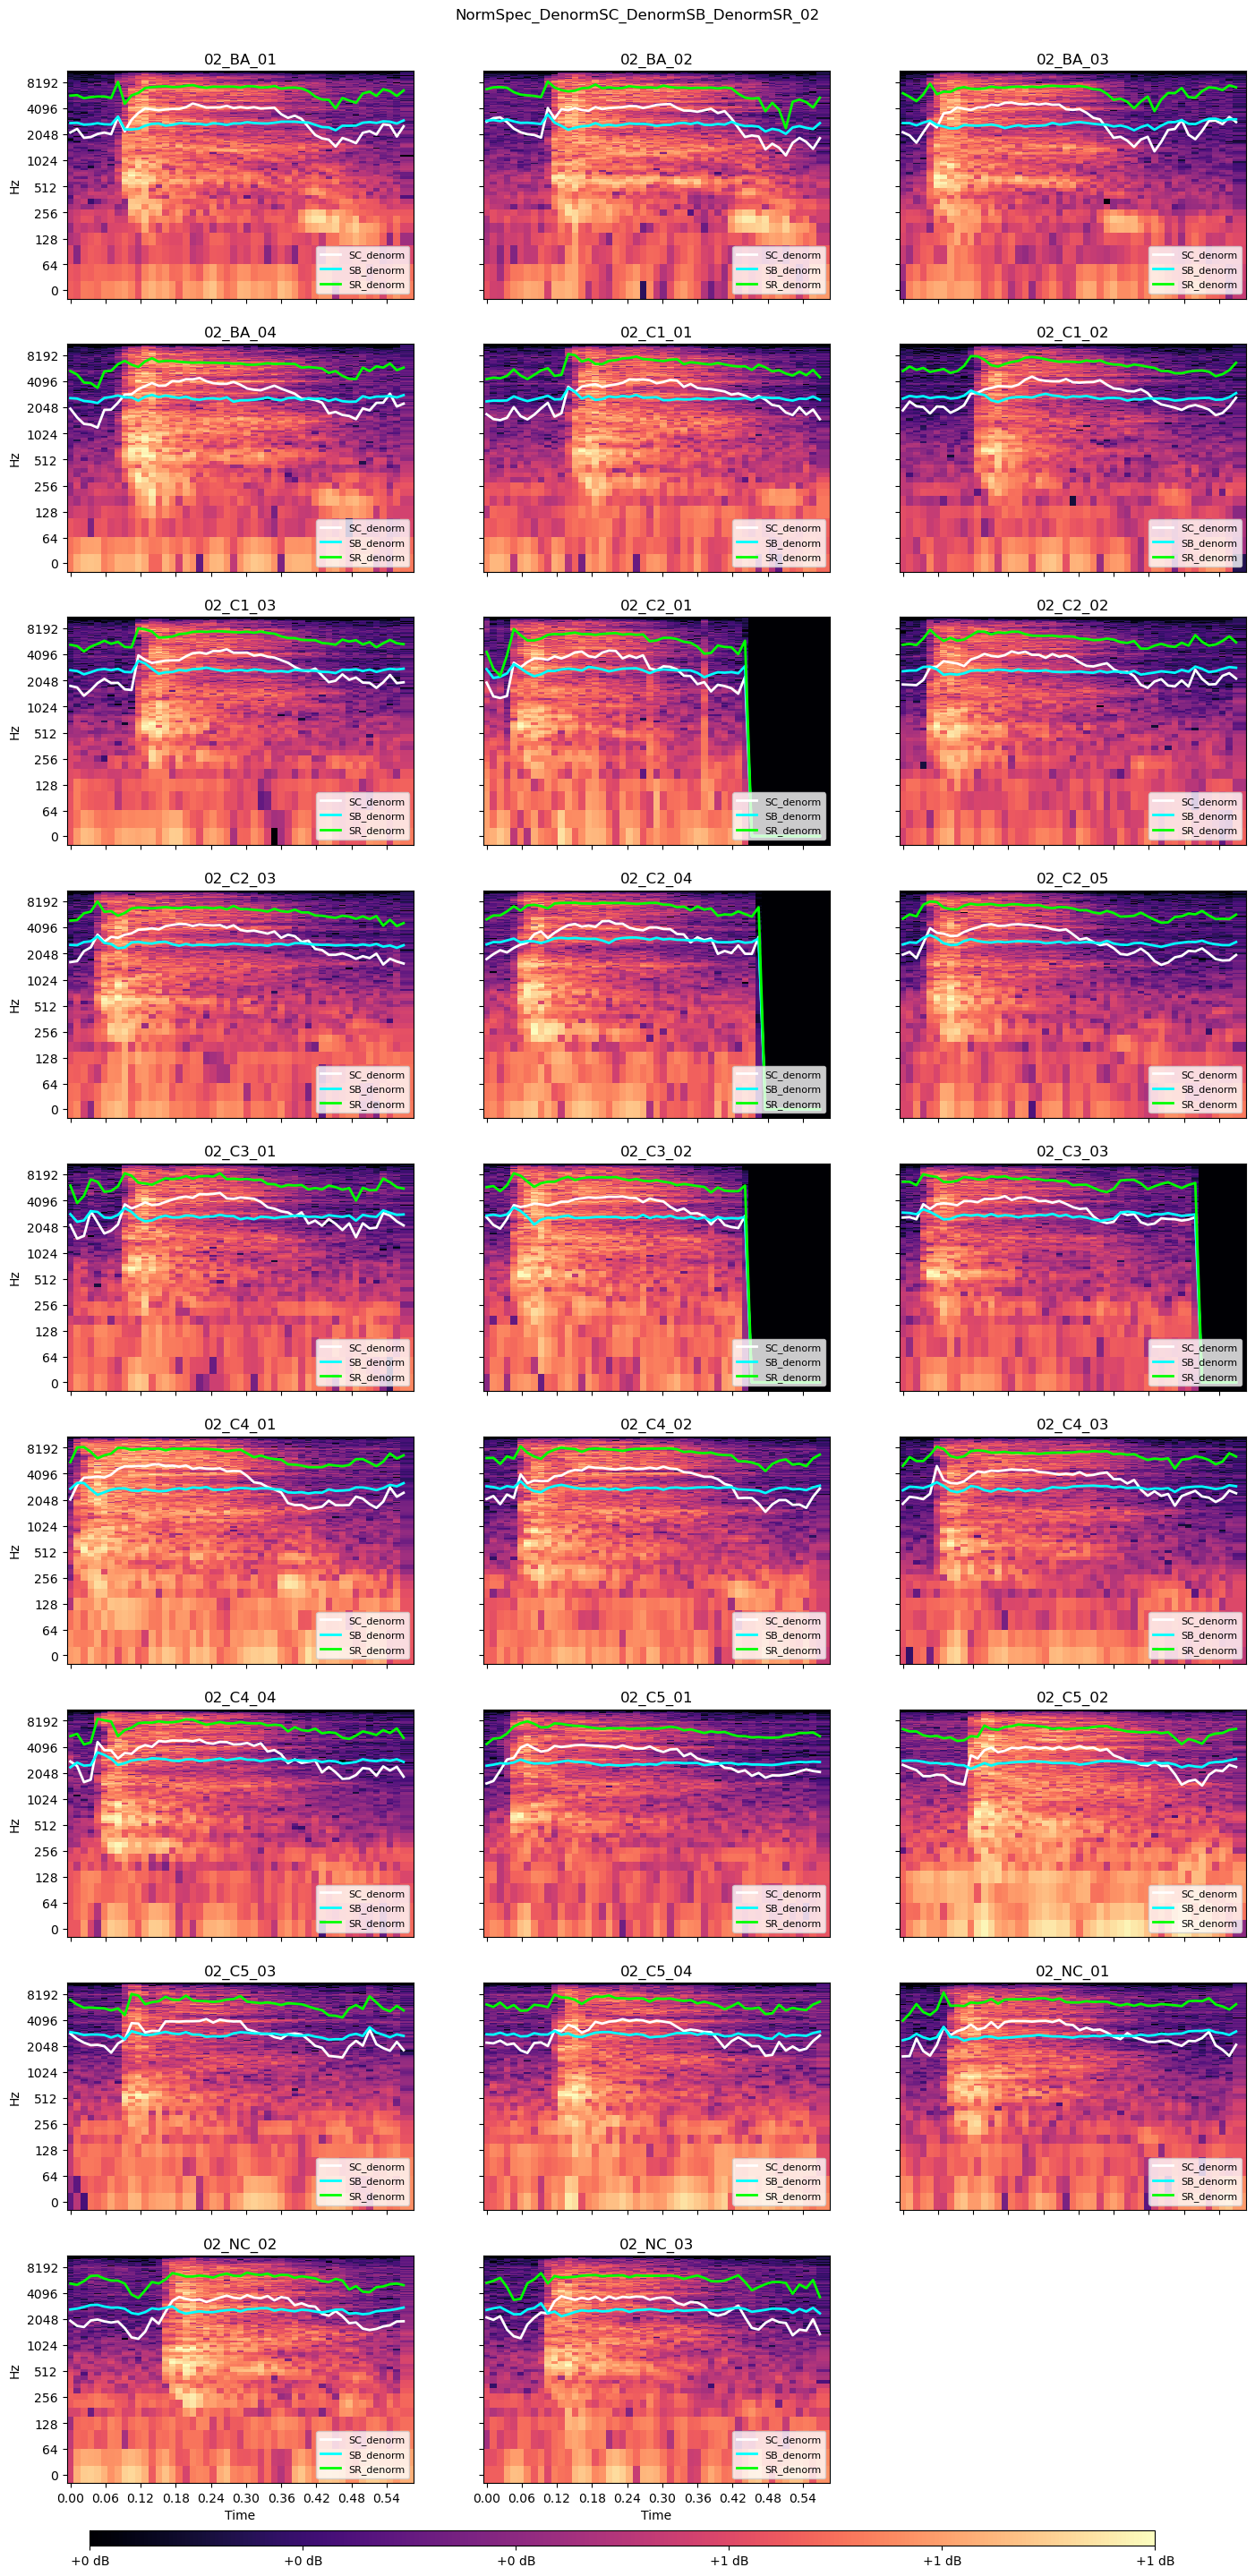

In [35]:
multi_plot_overlap_specshow(background_signals=[log_spectrograms[key] for key in log_spectrograms.keys()
                                                if '02_' in key],
                            foreground_signals=[[denorm_spectral_centroids[key],
                                                 denorm_spectral_bandwidths[key],
                                                 denorm_spectral_rolloffs[key]]
                                                for key in denorm_spectral_centroids.keys() if '02_' in key],
                            titles=[key for key in log_spectrograms.keys() if '02_' in key], plot='spec',
                            labels_foreground_signals=['SC_denorm', 'SB_denorm', 'SR_denorm'], num_row=9, num_col=3,
                            frame_size=None, fig_size=(17, 35), suptitle='NormSpec_DenormSC_DenormSB_DenormSR_02',
                            x_suptitle=0.5, y_suptitle=0.9, hop_length=256, legend_location='lower right',
                            legend_fontsize=8, x_axis='time', y_axis='log', cax=[0.14, 0.09, 0.7, 0.005],
                            orientation='horizontal', label_outer=True)

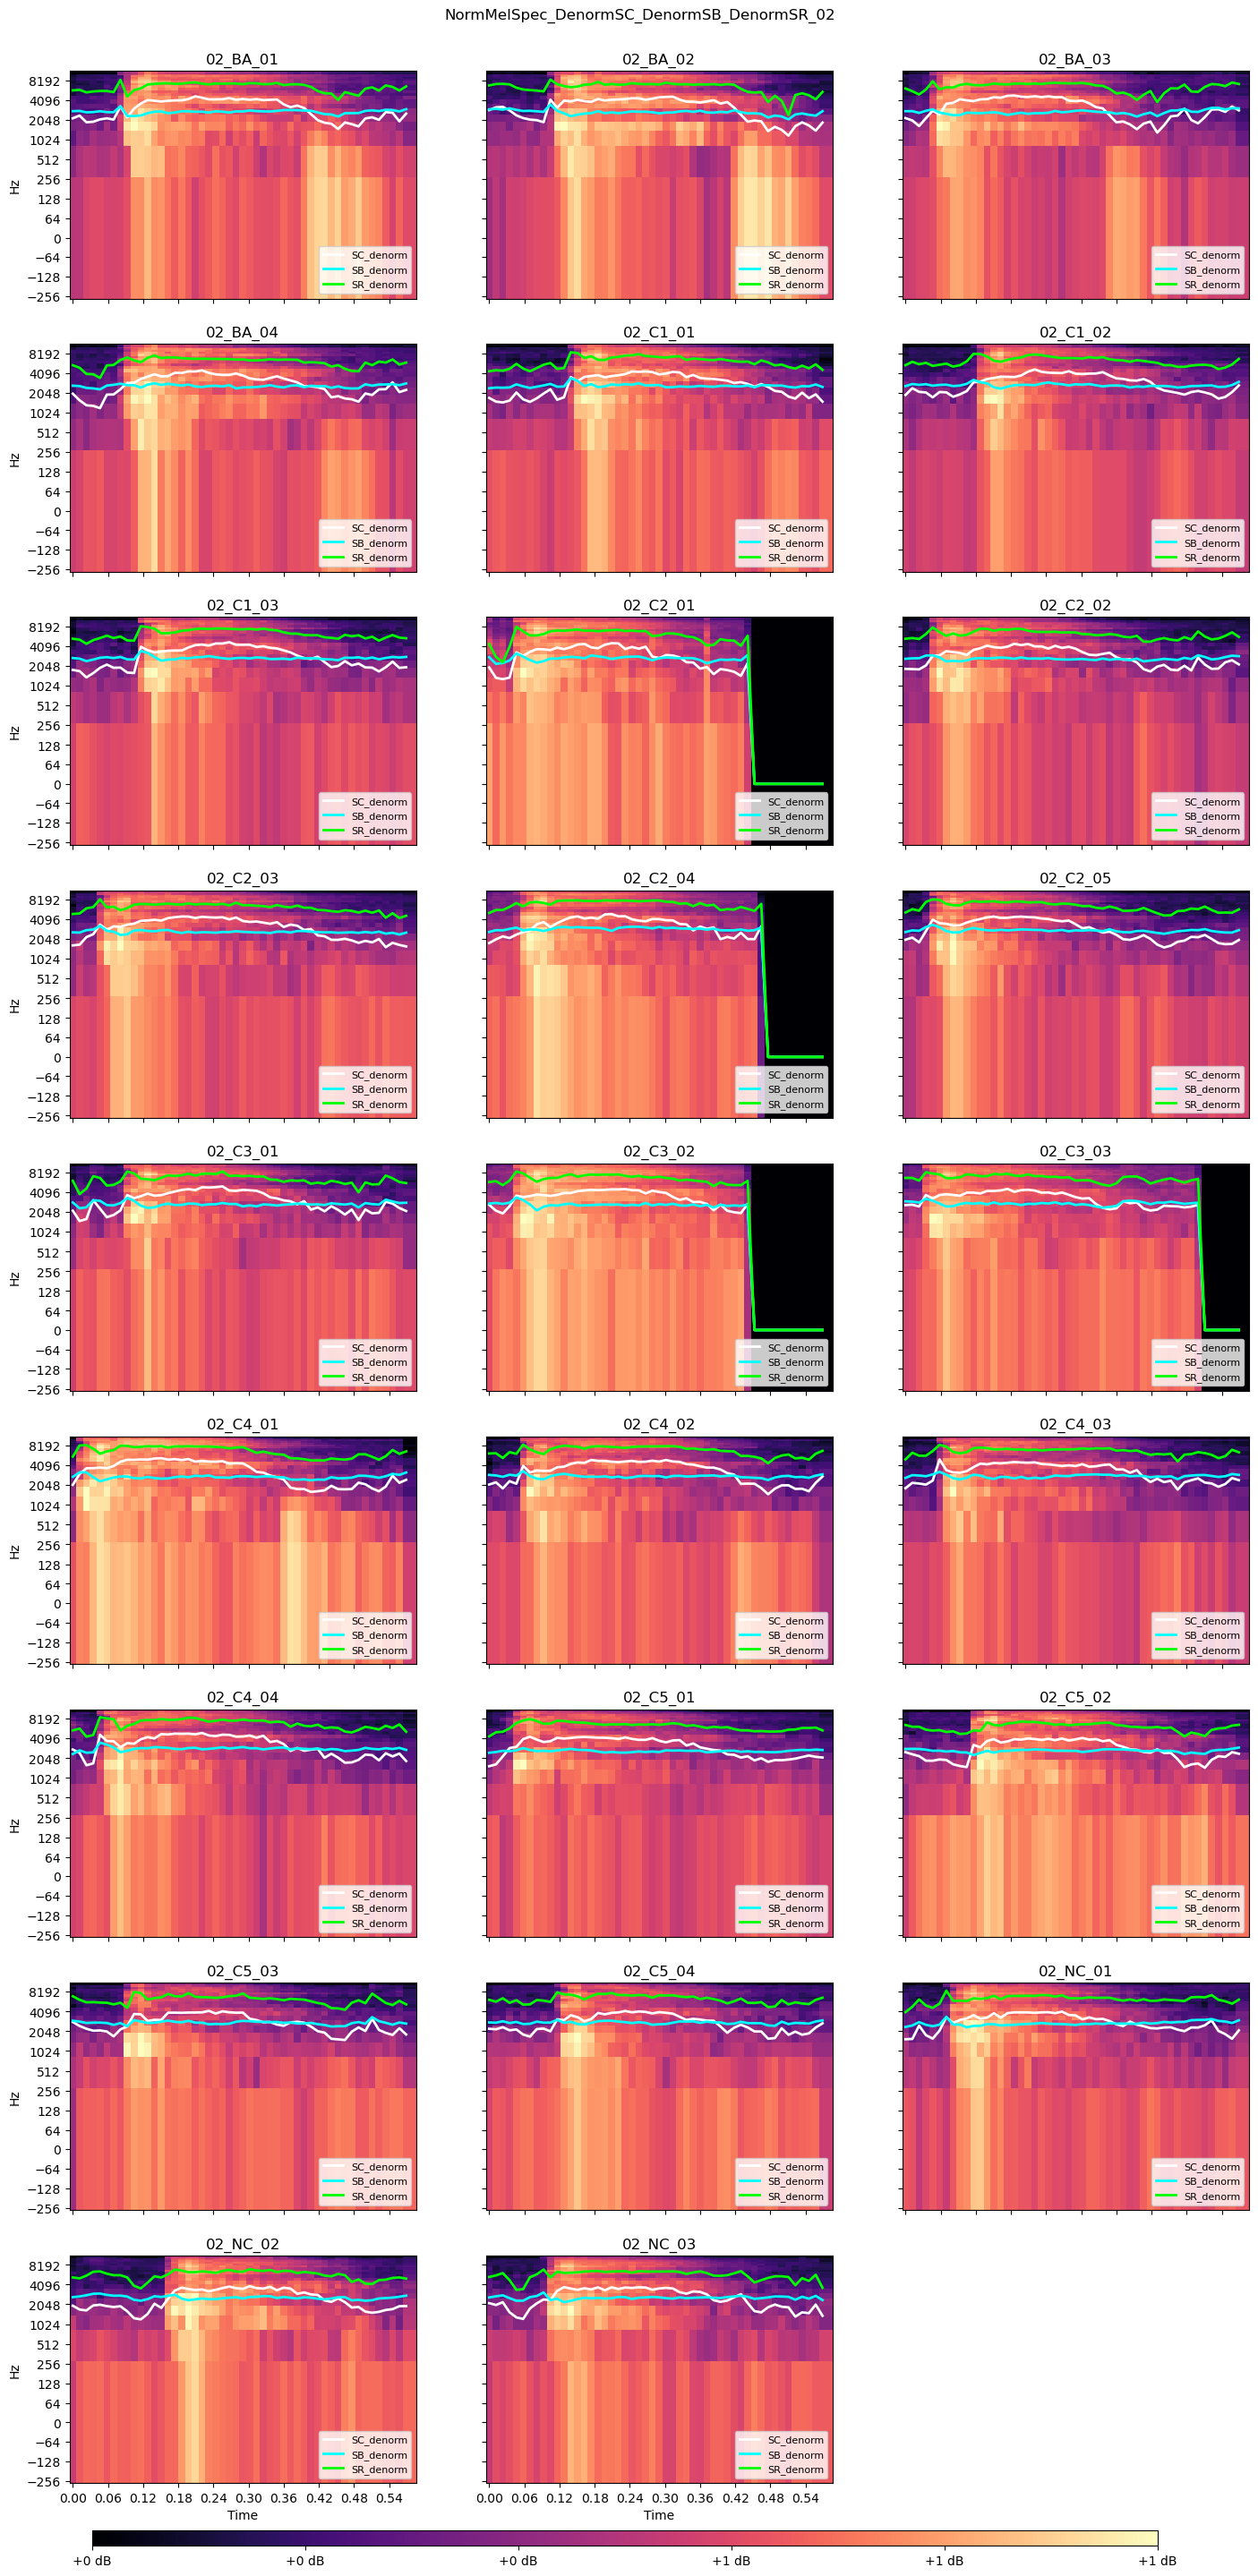

In [36]:
multi_plot_overlap_specshow(background_signals=[log_melspectrograms[key] for key in log_melspectrograms.keys()
                                                if '02_' in key],
                            foreground_signals=[[denorm_spectral_centroids[key],
                                                 denorm_spectral_bandwidths[key],
                                                 denorm_spectral_rolloffs[key]]
                                                for key in denorm_spectral_centroids.keys() if '02_' in key],
                            titles=[key for key in log_melspectrograms.keys() if '02_' in key], plot='mel_spec',
                            labels_foreground_signals=['SC_denorm', 'SB_denorm', 'SR_denorm'], num_row=9, num_col=3,
                            frame_size=None, fig_size=(17, 35), suptitle='NormMelSpec_DenormSC_DenormSB_DenormSR_02',
                            x_suptitle=0.5, y_suptitle=0.9, hop_length=256, legend_location='lower right',
                            legend_fontsize=8, x_axis='time', y_axis='log', cax=[0.14, 0.09, 0.7, 0.005],
                            orientation='horizontal', label_outer=True)

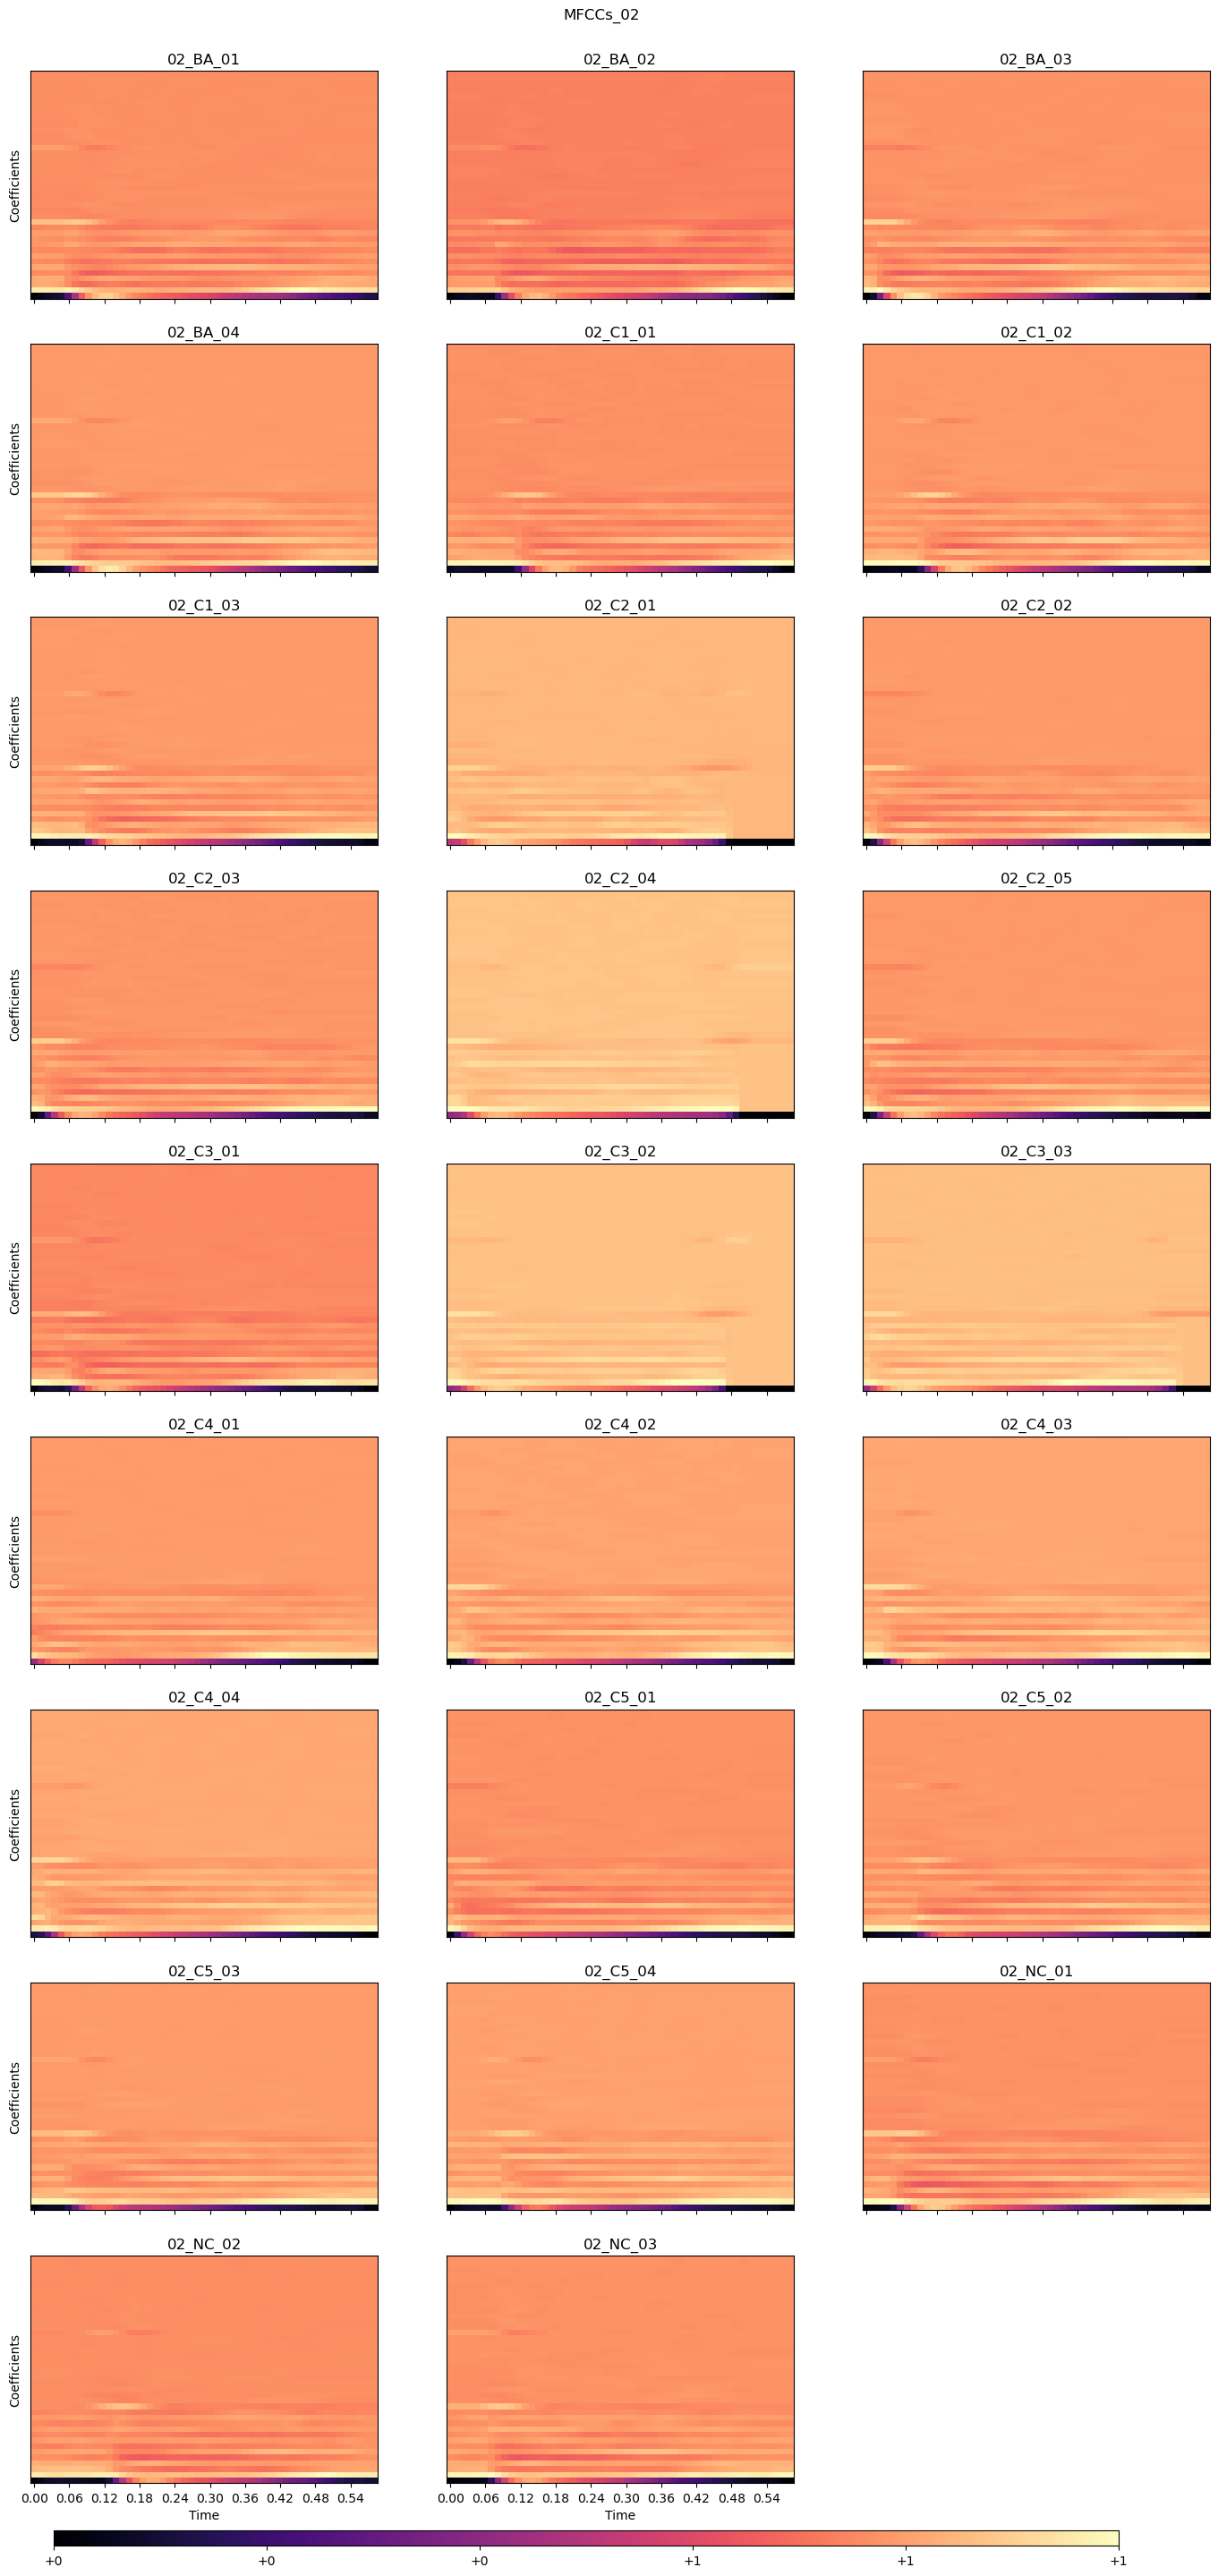

In [24]:
multi_plot_spectrogram([mfccs[key] for key in mfccs.keys() if '02_' in key],
                       [key for key in mfccs.keys() if '02_' in key], plot='mfcc',
                       num_row=9, num_col=3, fig_size=(17, 35), suptitle='MFCCs_02', x_suptitle=0.5, y_suptitle=0.90,
                       hop_length=256, x_axis='time', y_axis=None, cax=[0.14, 0.09, 0.7, 0.005], orientation='horizontal')

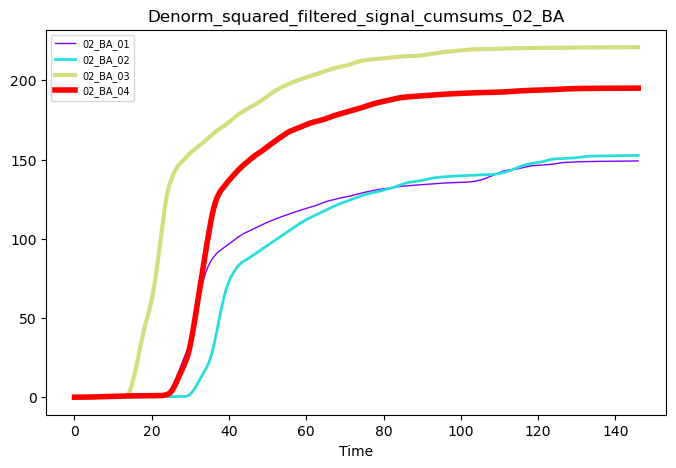

In [27]:
multi_plot_uneven(signals=[denorm_filtered_squared_cumsums[key] for key in denorm_filtered_squared_cumsums.keys()
                           if '02_BA' in key],
                  
                  titles=['Denorm_squared_filtered_signal_cumsums_02_BA'],
                  
                  labels=[key for key in denorm_filtered_squared_cumsums.keys() if '02_BA' in key],
                  
                  num_plot=1, num_row=1, num_col=1, fig_size=(8, 5), suptitle=None, x_suptitle=0.5, y_suptitle=0.96,
                  y_label=None, legend_location='upper left', legend_fontsize=7, label_outer=True,
                  sample_rate=22050, frame_size=512, hop_length=256)

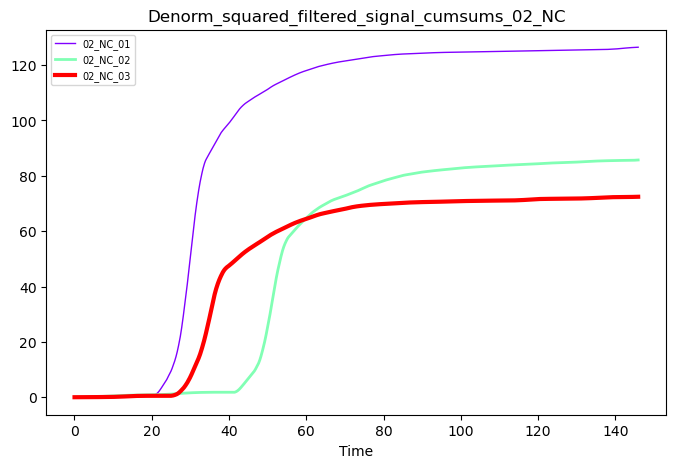

In [28]:
multi_plot_uneven(signals=[denorm_filtered_squared_cumsums[key] for key in denorm_filtered_squared_cumsums.keys()
                           if '02_NC' in key],
                  
                  titles=['Denorm_squared_filtered_signal_cumsums_02_NC'],
                  
                  labels=[key for key in denorm_filtered_squared_cumsums.keys() if '02_NC' in key],
                  
                  num_plot=1, num_row=1, num_col=1, fig_size=(8, 5), suptitle=None, x_suptitle=0.5, y_suptitle=0.96,
                  y_label=None, legend_location='upper left', legend_fontsize=7, label_outer=True,
                  sample_rate=22050, frame_size=512, hop_length=256)

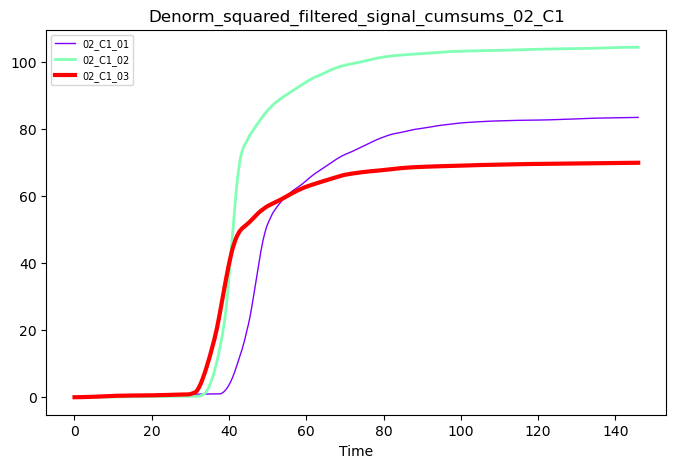

In [29]:
multi_plot_uneven(signals=[denorm_filtered_squared_cumsums[key] for key in denorm_filtered_squared_cumsums.keys()
                           if '02_C1' in key],
                  
                  titles=['Denorm_squared_filtered_signal_cumsums_02_C1'],
                  
                  labels=[key for key in denorm_filtered_squared_cumsums.keys() if '02_C1' in key],
                  
                  num_plot=1, num_row=1, num_col=1, fig_size=(8, 5), suptitle=None, x_suptitle=0.5, y_suptitle=0.96,
                  y_label=None, legend_location='upper left', legend_fontsize=7, label_outer=True,
                  sample_rate=22050, frame_size=512, hop_length=256)

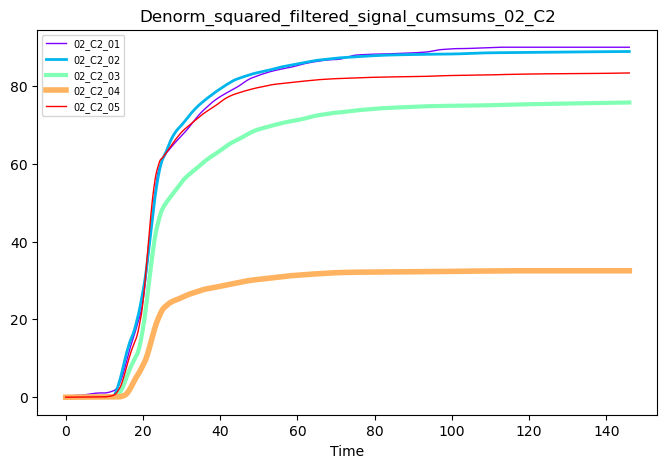

In [30]:
multi_plot_uneven(signals=[denorm_filtered_squared_cumsums[key] for key in denorm_filtered_squared_cumsums.keys()
                           if '02_C2' in key],
                  
                  titles=['Denorm_squared_filtered_signal_cumsums_02_C2'],
                  
                  labels=[key for key in denorm_filtered_squared_cumsums.keys() if '02_C2' in key],
                  
                  num_plot=1, num_row=1, num_col=1, fig_size=(8, 5), suptitle=None, x_suptitle=0.5, y_suptitle=0.96,
                  y_label=None, legend_location='upper left', legend_fontsize=7, label_outer=True,
                  sample_rate=22050, frame_size=512, hop_length=256)

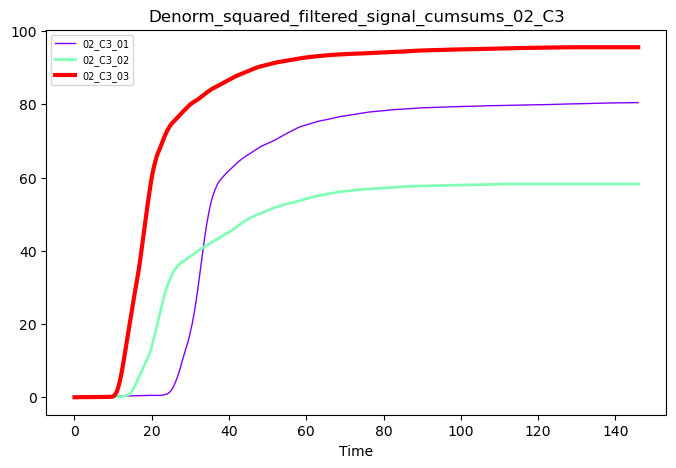

In [31]:
multi_plot_uneven(signals=[denorm_filtered_squared_cumsums[key] for key in denorm_filtered_squared_cumsums.keys()
                           if '02_C3' in key],
                  
                  titles=['Denorm_squared_filtered_signal_cumsums_02_C3'],
                  
                  labels=[key for key in denorm_filtered_squared_cumsums.keys() if '02_C3' in key],
                  
                  num_plot=1, num_row=1, num_col=1, fig_size=(8, 5), suptitle=None, x_suptitle=0.5, y_suptitle=0.96,
                  y_label=None, legend_location='upper left', legend_fontsize=7, label_outer=True,
                  sample_rate=22050, frame_size=512, hop_length=256)

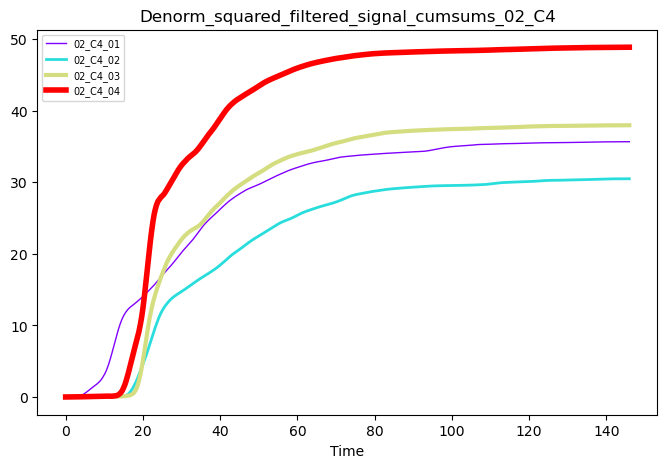

In [32]:
multi_plot_uneven(signals=[denorm_filtered_squared_cumsums[key] for key in denorm_filtered_squared_cumsums.keys()
                           if '02_C4' in key],
                  
                  titles=['Denorm_squared_filtered_signal_cumsums_02_C4'],
                  
                  labels=[key for key in denorm_filtered_squared_cumsums.keys() if '02_C4' in key],
                  
                  num_plot=1, num_row=1, num_col=1, fig_size=(8, 5), suptitle=None, x_suptitle=0.5, y_suptitle=0.96,
                  y_label=None, legend_location='upper left', legend_fontsize=7, label_outer=True,
                  sample_rate=22050, frame_size=512, hop_length=256)

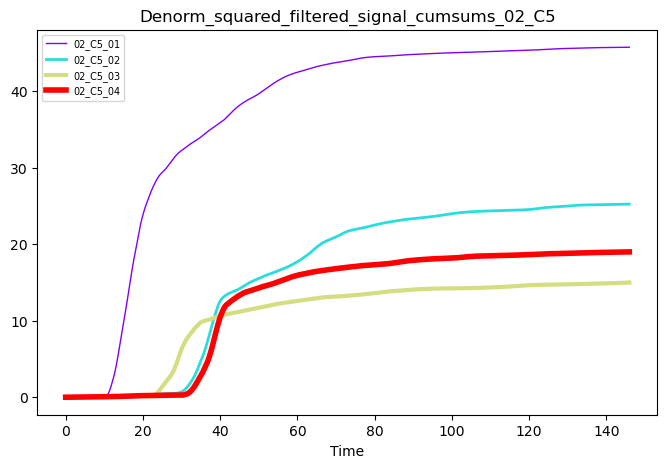

In [33]:
multi_plot_uneven(signals=[denorm_filtered_squared_cumsums[key] for key in denorm_filtered_squared_cumsums.keys()
                           if '02_C5' in key],
                  
                  titles=['Denorm_squared_filtered_signal_cumsums_02_C5'],
                  
                  labels=[key for key in denorm_filtered_squared_cumsums.keys() if '02_C5' in key],
                  
                  num_plot=1, num_row=1, num_col=1, fig_size=(8, 5), suptitle=None, x_suptitle=0.5, y_suptitle=0.96,
                  y_label=None, legend_location='upper left', legend_fontsize=7, label_outer=True,
                  sample_rate=22050, frame_size=512, hop_length=256)